<a href="https://colab.research.google.com/github/nicolaslepagecnam/REALIST-project/blob/main/test_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install perlin-noise
!pip install imageio
!pip install pyvista
!pip install pyvirtualdisplay
!pip instal tqdm
# !pip install vtk
# !pip install meshio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "instal" - maybe you meant "install"


In [ ]:
# !apt install ninja-build
# !cmake -G Ninja -DCMAKE_BUILD_TYPE=Release -B build-dir cpp/
# !ninja -j3 install -C build-dir
# !pip install python/. --upgrade

In [ ]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    from multidim_galerkin_pod.ldfnp_ext_cholmod import SparseFactorMassmat
except ImportError:
    !pip install git+https://github.com/highlando/spacetime_galerkin_pod.git
    from multidim_galerkin_pod.ldfnp_ext_cholmod import SparseFactorMassmat





import os
from collections import OrderedDict

import gmsh
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

import numpy.typing
import typing

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc
from dolfinx.fem.petsc import apply_lifting, assemble_matrix, assemble_vector, create_vector, set_bc
from dolfinx.graph import create_adjacencylist
from dolfinx.geometry import BoundingBoxTree, compute_collisions, compute_colliding_cells
# from dolfinx.io import (XDMFFile, cell_perm_gmsh, distribute_entity_data, extract_gmsh_geometry,
#                         extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh)

# from dolfinx.io import VTXWriter

from dolfinx.mesh import create_mesh, meshtags_from_entities

import ufl

from ufl import (FacetNormal, FiniteElement, Identity, Measure, TestFunction, TrialFunction, VectorElement,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym)

from perlin_noise import PerlinNoise

import random as rd

import imageio

import math, shelve

import time

import tqdm.notebook

from scipy.integrate import solve_ivp

import scipy.linalg as spla




--2023-01-21 12:39:22--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4252 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.15K  --.-KB/s    in 0s      

2023-01-21 12:39:23 (39.3 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4252/4252]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bd824e7/releases/pybind1

In [ ]:
!pip list

Package                       Version
----------------------------- -------------------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh                         2.3

In [ ]:
class NavierStokesProblem(object):
    """Define a nonlinear problem, interfacing with SNES."""
    
    def __init__(
        self, F: ufl.Form, J: ufl.Form, solution: dolfinx.fem.Function,
        bcs: typing.List[dolfinx.fem.DirichletBCMetaClass], P: typing.Optional[ufl.Form] = None ) -> None:
        self._F = dolfinx.fem.form(F)
        self._J = dolfinx.fem.form(J)
        self._obj_vec = dolfinx.fem.petsc.create_vector(self._F)
        self._solution = solution
        self._bcs = bcs
        self._P = P

    def create_snes_solution(self) -> PETSc.Vec:
        """
        Create a petsc4py.PETSc.Vec to be passed to petsc4py.PETSc.SNES.solve.

        The returned vector will be initialized with the initial guess provided in `self._solution`.
        """
        x = self._solution.vector.copy()
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _x[:] = _solution
        return x

    def update_solution(self, x: PETSc.Vec) -> None:
        """Update `self._solution` with data in `x`."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _solution[:] = _x

    def obj(self, snes: PETSc.SNES, x: PETSc.Vec) -> np.float64:
        """Compute the norm of the residual."""
        self.F(snes, x, self._obj_vec)
        return self._obj_vec.norm()

    def F(self, snes: PETSc.SNES, x: PETSc.Vec, F_vec: PETSc.Vec) -> None:
        """Assemble the residual."""
        self.update_solution(x)
        with F_vec.localForm() as F_vec_local:
            F_vec_local.set(0.0)
        dolfinx.fem.petsc.assemble_vector(F_vec, self._F)
        dolfinx.fem.apply_lifting(F_vec, [self._J], [self._bcs], x0=[x], scale=-1.0)
        F_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(F_vec, self._bcs, x, -1.0)
        # see for instance https://fenicsproject.discourse.group/t/how-to-set-bcs-for-petsc-matrices-and-petsc-vectors-in-dolfinx/4135
        # for the BC treatment

    def J(
        self, snes: PETSc.SNES, x: PETSc.Vec, J_mat: PETSc.Mat,
        P_mat: PETSc.Mat
    ) -> None:
        """Assemble the jacobian."""
        J_mat.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(J_mat, self._J, self._bcs, diagonal=1.0)
        J_mat.assemble()
        if self._P is not None:
            P_mat.zeroEntries()
            dolfinx.fem.petsc.assemble_matrix(P_mat, self._P, self._bcs, diagonal=1.0)
            P_mat.assemble()

In [ ]:
import random as rd
import scipy.signal

class boundary():
        def __init__(self):
            pass

        def __call__(self, x):
            
            noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType)  #+ 0.4
            
            return noised

class boundary2():
        def __init__(self):
            pass

        def __call__(self, x):
            
            noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType)
            
            return noised
  
    
# class Initial():
#     def __init__(self,i):

#         octa = 6

#         self.noise = PerlinNoise(octaves=octa, seed = i )

#     def __call__(self, x):

#         self.pos =  x[0,:]

#         noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType) + 0.4

#         noised += [1.5*self.noise([i]) for i in x[0,:]]

#         plt.plot( x[0,:], noised[0,:])

#         plt.show()

#         return noised

class Initial():
    def __init__(self, index, number):

        self.octa = 20

        # self.noise = PerlinNoise(octaves=octa, seed = i )

        self.index = index

        self.number = number

    def __call__(self, x):

        print("init cond")

        self.pos =  x[0,:]

        noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType) # + 0.4

        noised[0,int(x.shape[1]*0.2)] += 1

        # mult = 1

        # for j in range(1,self.octa+1):

        #   seed_index = self.index*20 + j

        #   noise = PerlinNoise(octaves=j, seed = seed_index)

        #   noised += [mult* 1.5*noise([k]) for k in x[0,:]]

        #   # plt.plot( x[0,:], noised[0,:])

        #   # plt.show()

        #   if self.number == 0:

        #     mult *=0.85

        #   else :
        #     mult *=0.855

        return noised

class Initial_KS():
    def __init__(self):
      pass

    def __call__(self, x):

        print("init cond")

        self.pos =  x[0,:]

        noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType) # + 0.4

        noised[0,int(x.shape[1]*0.45)] += 1 #+ 0.1*rd.random()

        return noised

def simulation_perlin( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001 ):

        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ##################################################################################fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD

        mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        s_cg1 = FiniteElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        facets = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))
        
        u_inlet = Function(W)
        inlet_velocity = boundary()
        u_inlet.interpolate(inlet_velocity)

        sides = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, facets))    

        bc = [sides]
        
        u = Function(W)
        du = ufl.TrialFunction(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial(100)
        u_n.interpolate(init)
        # pos = init.pos

        # new_pos = np.zeros((u_n.vector[:].shape[0]))

        # n = 3

        # for i in range(u_n.vector[:].shape[0]):
        #   if i % n != 0 :
        #     new_pos
          

        

        # F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
        # + inner(u.dx(0) * u_n, v) * ufl.dx
        # + inner(u.dx(0), v.dx(0)) * ufl.dx
        # # + inner(u.dx(0).dx(0), v.dx(0).dx(0)) * ufl.dx
        # )

        list_u = np.zeros((u_n.vector[:].shape[0], num_steps))

        ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

        # u_temp = Function(W)

        # bar de progression du calcul

        # boucle de resolution

        j = 1

        list_u[:,0] = u_n.vector[:]

        # print(pos.shape)
        # print(u_n.vector[:].shape)

        # plt.plot(pos, u_n.vector[:])

        # plt.show()

        # print(u_n.vector[:])

        # a = form(lhs(F1))
        # L = form(rhs(F1))
        # A = assemble_matrix(a, bcs=bc)
        # A.assemble()
        # b = create_vector(L)

        # solver1 = PETSc.KSP().create(mesh.comm)
        # solver1.setOperators(A)
        # solver1.setType("preonly")
        # solver1.setConvergenceHistory()
        # pc1 = solver1.getPC()
        # pc1.setType("lu")
        # # pc1.setFactorPivot(zeropivot=10e-10)
        # pc1.setFactorSolverType("mumps")

        progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)

        for i in range(num_steps-1):

            progress.update(1)

            F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
            + inner(u.dx(0) * u, v) * ufl.dx
            + nu_petsc * inner(u.dx(0), v.dx(0)) * ufl.dx
            # + inner(u.dx(0).dx(0), v.dx(0).dx(0)) * ufl.dx
            )


            J = ufl.derivative(F1, u, du)

            problem = NavierStokesProblem(F1, J, u, bc)
            F_vec = dolfinx.fem.petsc.create_vector(problem._F)
            J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

            snes = PETSc.SNES().create(mesh.comm)
            snes.setTolerances(max_it=50, rtol = 10e-15)
            snes.getKSP().setType("preonly")
            snes.getKSP().getPC().setType("lu")
            snes.getKSP().getPC().setFactorSolverType("mumps")
            snes.setObjective(problem.obj)
            snes.setFunction(problem.F, F_vec)
            snes.setJacobian(problem.J, J=J_mat, P=None)
            snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.2e"%(it,residual)))
            up_copy = problem.create_snes_solution()
            snes.solve(None, up_copy)
            problem.update_solution(up_copy)

            # A = assemble_matrix(a, bcs=bc)
            # A.assemble()
            # solver1.setOperators(A)

            # # resolution
            # with b.localForm() as loc:
            #     loc.set(0)
            # assemble_vector(b, L)
            # apply_lifting(b, [a], [bc])
            # b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            # set_bc(b, bc)
            
            # solver1.solve(b, u_temp.vector)
            # u_temp.x.scatter_forward()

            list_u[:,j] = up_copy[:]

            j += 1
            # Update variable with solution form this time step
            with up_copy.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)
        
        return list_u

def simulation_KS( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001, index = 0, number = 0):
    
        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ##################################################################################fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD
    
        mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        s_cg1 = FiniteElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        facets = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        print(facets)

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))
        
        u_inlet = Function(W)
        inlet_velocity = boundary()
        
        u_inlet.interpolate(inlet_velocity)

        sides = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, facets))    

        bc = [sides]
        
        u = Function(W)
        du = ufl.TrialFunction(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial(index, number)
        u_n.interpolate(init)

        list_u = np.zeros((u_n.vector[:].shape[0], num_steps))

        j = 1

        list_u[:,0] = u_n.vector[:]

        h = ufl.CellDiameter(mesh)
        h_avg = (h('+') + h('-'))/2.0
        n = ufl.FacetNormal(mesh)
        alpha = Constant(mesh, PETSc.ScalarType(1))

        progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)

        for i in range(num_steps-1):

            progress.update(1)

            # F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
            # + inner(u.dx(0) * u, v) * ufl.dx
            # + nu_petsc * inner(u.dx(0), v.dx(0)) * ufl.dx
            # + inner(u.dx(0).dx(0), v.dx(0).dx(0)) * ufl.dx
            # )

            F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
            + inner(u.dx(0) * u, v) * ufl.dx
            - nu_petsc * inner(u.dx(0), v.dx(0)) * ufl.dx
            + 0.0001 * nu_petsc *(inner(ufl.div(ufl.grad(u)), ufl.div(ufl.grad(v)))*ufl.dx
            - inner(ufl.avg(ufl.div(ufl.grad(u))), ufl.jump(ufl.grad(v), n))*ufl.dS
            - inner(ufl.jump(ufl.grad(u), n), ufl.avg(ufl.div(ufl.grad(v))))*ufl.dS 
            + alpha('+')/h_avg*inner(ufl.jump(ufl.grad(u),n), ufl.jump(ufl.grad(v),n))*ufl.dS)
            )

            J = ufl.derivative(F1, u, du)

            problem = NavierStokesProblem(F1, J, u, bc)
            F_vec = dolfinx.fem.petsc.create_vector(problem._F)
            J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

            snes = PETSc.SNES().create(mesh.comm)
            snes.setTolerances(max_it=50, rtol = 10e-15)
            snes.getKSP().setType("preonly")
            snes.getKSP().getPC().setType("lu")
            # snes.getKSP().getPC().setFactorSolverType("mumps")
            snes.setObjective(problem.obj)
            snes.setFunction(problem.F, F_vec)
            snes.setJacobian(problem.J, J=J_mat, P=None)
            snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.2e"%(it,residual)))
            up_copy = problem.create_snes_solution()
            snes.solve(None, up_copy)
            problem.update_solution(up_copy)

            list_u[:,j] = up_copy[:]
            print(np.amax(np.absolute(up_copy[:])))

            j += 1

            # Update variable with solution form this time step
            with up_copy.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)
        
        return list_u

def simulation_KS_bis( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001, index = 0, number = 0):

        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ################################################################################## fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD

        # mesh = dolfinx.mesh.create_interval(rank, nx = precision, points=[0,1])
        mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        v_cg2 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        s_cg1 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        W_element = ufl.MixedElement(v_cg2, s_cg1)
        W = FunctionSpace(mesh, W_element)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        def on_top_boundary(x):
          return(np.isclose(x[0], 0.0))

        W0, submap0 = W.sub(0).collapse()

        W1, submap1 = W.sub(1).collapse()

        facets0 = dolfinx.fem.locate_dofs_geometrical((W.sub(0),W0), on_top_boundary)

        print(facets0)
        facets1 = dolfinx.fem.locate_dofs_geometrical((W.sub(1),W1), on_top_boundary)
        print(facets1)

        t = 0
        T = time_horizon
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))
        
        uv_inlet = Function(W)
        u_inlet, v_inlet = uv_inlet.split()
        inlet_velocity = boundary()
        inlet_v = boundary2()
        u_inlet.interpolate(inlet_velocity)
        v_inlet.interpolate(inlet_v)

        sides0 = dirichletbc(u_inlet, locate_dofs_topological(W.sub(0), fdim, facets0))    
        sides1 = dirichletbc(v_inlet, locate_dofs_topological(W.sub(1), fdim, facets1))  

        # print(sides1)  

        bc = [sides0,sides1]
        
        uv = Function(W)
        u,v = uv.split()
        duv = ufl.TrialFunction(W)

        qz = ufl.TestFunction(W)
        (q, z) = ufl.split(qz)
        
        uv_n = Function(W)
        u_n,v_n = uv_n.split()

        init = Initial(index, number)
        u_n.interpolate(init)

        list_u = np.zeros((u_n.vector[:].shape[0], num_steps))

        j = 1

        list_u[:,0] = u_n.vector[:]

        progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)

        for i in range(num_steps-1):

            progress.update(1)

            F1 = ((1/k)*inner(u - u_n, q)* ufl.dx
            + inner(u.dx(0) * u, q) * ufl.dx
            + nu_petsc *inner(v, q) * ufl.dx
            - 0.0001 * nu_petsc * inner(v.dx(0), q.dx(0)) * ufl.dx
            + inner(v, z) * ufl.dx
            + inner(u.dx(0), z.dx(0)) * ufl.dx)

            J = ufl.derivative(F1, uv, duv)

            problem = NavierStokesProblem(F1, J, uv, bc)
            F_vec = dolfinx.fem.petsc.create_vector(problem._F)
            J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

            snes = PETSc.SNES().create(mesh.comm)
            snes.setTolerances(max_it=50, rtol = 10e-15)
            snes.getKSP().setType("preonly")
            snes.getKSP().getPC().setType("lu")
            snes.getKSP().getPC().setFactorSolverType("mumps")
            snes.setObjective(problem.obj)
            snes.setFunction(problem.F, F_vec)
            snes.setJacobian(problem.J, J=J_mat, P=None)
            snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.2e"%(it,residual)))
            uv_copy= problem.create_snes_solution()
            snes.solve(None, uv_copy)
            problem.update_solution(uv_copy)

            print(np.amax(np.absolute(uv_copy[:])))

            # Update variable with solution form this time step
            with uv_copy.localForm() as loc_u, uv_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)

            list_u[:,j] = u_n.vector[:]

            j += 1
        
        return list_u

def simulation_KS_expli(t = 250, dt = 0.01, N = 400, order = 2, gamma = 1, mu_factor = 1):

        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ################################################################################## fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD

        mesh = dolfinx.mesh.create_interval(rank, nx = precision, points=[-100,100])
        # mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        v_cg2 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        s_cg1 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        W_element = ufl.MixedElement(v_cg2, s_cg1)
        W = FunctionSpace(mesh, W_element)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        def on_top_boundary(x):
          return(np.isclose(x[0], -100))

        W0, submap0 = W.sub(0).collapse()

        W1, submap1 = W.sub(1).collapse()

        facets0 = dolfinx.fem.locate_dofs_geometrical((W.sub(0),W0), on_top_boundary)

        # print(facets0)
        facets1 = dolfinx.fem.locate_dofs_geometrical((W.sub(1),W1), on_top_boundary)
        # print(facets1)

        t = 0
        T = time_horizon
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))

        x = ufl.SpatialCoordinate(mesh)
        # mu = (mu_factor*3.95) * ufl.exp(-(x[0]+10)**2) + mu_factor*3.95 * ufl.exp(-(x[0]+5)**2) + mu_factor*3.95 * ufl.exp(-(x[0])**2) + mu_factor*3.95 * ufl.exp(-(x[0]-5)**2) + mu_factor*3.95 * ufl.exp(-(x[0]-10)**2) 
        
        mu = (mu_factor*3.95) * ufl.exp(-(x[0])**2)

        gamma_petsc = Constant(mesh, PETSc.ScalarType(gamma))
        
        uv_inlet = Function(W)
        u_inlet, v_inlet = uv_inlet.split()
        inlet_velocity = boundary()
        inlet_v = boundary2()
        u_inlet.interpolate(inlet_velocity)
        v_inlet.interpolate(inlet_v)

        sides0 = dirichletbc(u_inlet, locate_dofs_topological(W.sub(0), fdim, facets0))    
        sides1 = dirichletbc(v_inlet, locate_dofs_topological(W.sub(1), fdim, facets1))  

        # print(sides1)  

        bc = [sides0,sides1]
        
        uv = ufl.TrialFunction(W)
        u,v = ufl.split(uv)
        # duv = ufl.TrialFunction(W)

        qz = ufl.TestFunction(W)
        (q, z) = ufl.split(qz)
        
        uv_n = Function(W)
        u_n,v_n = uv_n.split()

        F1 = ((1/k)*inner(u - u_n, q)* ufl.dx
        + inner(u.dx(0) * (1 + u_n), q) * ufl.dx
        + mu * inner(v, q) * ufl.dx
        - gamma_petsc * inner(v.dx(0), q.dx(0)) * ufl.dx
        + inner(v, z) * ufl.dx
        + inner(u.dx(0), z.dx(0)) * ufl.dx)

        init = Initial_KS()
        u_n.interpolate(init)

        list_u = np.zeros((uv_n.vector[:].shape[0], int(num_steps/1)))

        j = 1

        list_u[:,0] = uv_n.vector[:]

        progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)

        uv_temp = Function(W)
        u_,v_ = uv_temp.split()

        a = form(lhs(F1))
        L = form(rhs(F1))
        A = assemble_matrix(a, bcs=bc)
        A.assemble()
        b = create_vector(L)  

        print(A.getInfo())
        print(A.isSymmetric())
        print(A.size)

        ### parametres du solver 

        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A)
        solver1.setType("preonly")
        solver1.setConvergenceHistory()
        pc1 = solver1.getPC()
        pc1.setType("lu")
        # pc1.setFactorPivot(zeropivot=10e-10)
        pc1.setFactorSolverType("mumps")

        for i in range(1,num_steps):

            # u_inlet.interpolate(inlet_velocity)
            # sides0 = dirichletbc(u_inlet, locate_dofs_topological(W.sub(0), fdim, facets0)) 
            # bc = [sides0,sides1]

            progress.update(1)

            A = assemble_matrix(a, bcs=bc)
            A.assemble()
            solver1.setOperators(A)

            t += dt
            # Update inlet velocity
            # inlet_velocity.t = t
            # u_inlet.interpolate(inlet_velocity)
            
            # resolution
            with b.localForm() as loc:
                loc.set(0)
            assemble_vector(b, L)
            apply_lifting(b, [a], [bc])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            set_bc(b, bc)
            solver1.solve(b, uv_temp.vector)
            uv_temp.x.scatter_forward()   

            # if i%10 == 0 :

            #     # (u_f, p_f) = (uv_temp.sub(0).collapse(), uv_temp.sub(1).collapse())

            #     residual = A * uv_temp.vector - b

            #     print( f"The relative residual is: {residual.norm() }." )#/ b.norm()

            #     print(np.amax(np.absolute(uv_temp.sub(0).vector[:])))

            # Update variable with solution form this time step
            with uv_temp.vector.localForm() as loc_u, uv_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)

            if i%1 == 0 :

              # print(j)

              list_u[:,j] = uv_n.vector[:]

              j += 1
        
        return list_u
    
def print_result(x):
    
    filenames = []

    with imageio.get_writer('test_FEM.gif', mode='I') as writer:

        for j in range(0, x.shape[1],1):

            plt.plot(x[::2,j], "r")   
            plt.ylim(-0.5, 1)

            # create file name and append it to a list
            filename = f'{j}.png'

            # save frame
            plt.savefig(filename)
            plt.close()

            # build gif

            image = imageio.imread(filename)
            writer.append_data(image)

            os.remove(filename)


def print_result_bis(x,y):

    filenames = []

    with imageio.get_writer('test_FEM_bis.gif', mode='I') as writer:

        for j in range(0, x.shape[1],1):



            plt.plot(x[::4,j], "r")   
            plt.plot(y[::2,j], "blue")  
            plt.ylim(-1.5, 1.5)

            # create file name and append it to a list
            filename = f'{j}.png'

            # save frame
            plt.savefig(filename, dpi=150)
            plt.close()

            # build gif

            image = imageio.imread(filename)
            writer.append_data(image)

            os.remove(filename)

def print_result_bis_n(n):

    filenames = []

    with imageio.get_writer('test_FEM_bis.gif', mode='I') as writer:

      for i in range(n):

        traj_1 = simulation_KS_expli(t = 100, dt = 0.01, N = 400, order = 2, gamma = 1, mu_factor = 1)


        # print(traj_1.shape[1])

        # # plt.plot(traj_1[0::2,:][250,:],traj_1[0::2,:][290,:])
        # plt.plot(traj_1[0::2,:][300,:])

        # plt.show()

        # freq, spectrum = scipy.signal.welch(traj_1[0::2,:][350,200:],  fs = 1, nperseg = 150)

        # plt.plot(freq,spectrum)

        # plt.show()

        # MSE  = np.sum(np.power(traj_1[0::2,:200]-traj_2[0::2,:200],2), axis = 0)

        # plt.plot(numpy.log(MSE))



        # print(freq[np.argmax(spectrum)])

    #     plt.show()

        # progress = tqdm.notebook.tqdm(desc="Solving PDE", total=int(traj_1.shape[1]))

        # for j in range(0, traj_1.shape[1],1):

        #     print(j)

        #     x = np.linspace(-100,100,400)

        #     y = (3.95) * np.exp(-(x)**2)

        #     plt.plot(traj_1[0::4,j]) # semble etre v
        #     # plt.plot(traj_1[1::4,j]) # semble etre v
        #     # plt.plot(traj_1[2::4,j]) # semble etre u
        #     plt.plot(traj_1[3::4,j]) # semble etre u
        #     # plt.plot(traj_2[0::2,j])
        #     # plt.plot(traj_3[0::2,j])
        #     # plt.plot(traj_4[0::2,j])
        #     # plt.plot(traj_5[0::2,j])

        #     plt.plot(y,"b") 
        #     plt.ylim(-5, 5)

        #     # create file name and append it to a list
        #     filename = f'{j}.png'

        #     # save frame
        #     plt.savefig(filename, dpi=100)

        #     plt.show()
        #     plt.close()

        #     # build gif

        #     image = imageio.imread(filename)
        #     writer.append_data(image)

        #     os.remove(filename)
        #     progress.update(1)

    # plt.imshow(traj_1[0::2,:])

    # plt.show()

    return traj_1

In [ ]:
traj_1 = print_result_bis_n(1)



init cond


Solving PDE:   0%|          | 0/10000 [00:00<?, ?it/s]

{'block_size': 1.0, 'nz_allocated': 12804.0, 'nz_used': 12804.0, 'nz_unneeded': 0.0, 'memory': 0.0, 'assemblies': 1.0, 'mallocs': 0.0, 'fill_ratio_given': 0.0, 'fill_ratio_needed': 0.0, 'factor_mallocs': 0.0}
False
(1602, 1602)


In [ ]:
# sum = 0
# print(svals)
# for i in range(len(svals)) :
#   sum += svals[i]/np.sum(svals)
#   print(sum)
#   print(i+1)
#   if sum >= 0.99 :
#     break

# selected_podmodes = podmodes[:, :i]

# print(selected_podmodes.shape)

# plt.plot(np.transpose(selected_podmodes)[0][1::4])
# plt.plot(np.transpose(selected_podmodes)[0][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[1][1::4])
# plt.plot(np.transpose(selected_podmodes)[1][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[2][1::4])
# plt.plot(np.transpose(selected_podmodes)[2][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[3][1::4])
# plt.plot(np.transpose(selected_podmodes)[3][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[4][1::4])
# plt.plot(np.transpose(selected_podmodes)[4][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[5][1::4])
# plt.plot(np.transpose(selected_podmodes)[5][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[6][1::4])
# plt.plot(np.transpose(selected_podmodes)[6][2::4])
# plt.show()
# plt.plot(np.transpose(selected_podmodes)[7][::4])
# plt.plot(np.transpose(selected_podmodes)[7][2::4])
# plt.show()

# podmodes_red = podmodes

In [47]:
def nonlinear(y,N): # Non-linear function in reduced-order model
  rhs=np.zeros(y.shape, dtype=float)
  for i in range(0,y.shape[0]):
      rhs[i]=y.transpose().dot(N[:,:,i].dot(y))
  return rhs

def simulation_KS_expli_red(snaps, t = 250, dt = 0.01, N = 400, order = 2, gamma = 1, mu_factor = 1):

        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ################################################################################## fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD

        mesh = dolfinx.mesh.create_interval(rank, nx = precision, points=[-100,100])
        # mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        v_cg2 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        s_cg1 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        W_element = ufl.MixedElement(v_cg2, s_cg1)
        W = FunctionSpace(mesh, W_element)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        def on_top_boundary(x):
          return(np.isclose(x[0], -100))

        W0, submap0 = W.sub(0).collapse()

        W1, submap1 = W.sub(1).collapse()

        facets0 = dolfinx.fem.locate_dofs_geometrical((W.sub(0),W0), on_top_boundary)

        # print(facets0)
        facets1 = dolfinx.fem.locate_dofs_geometrical((W.sub(1),W1), on_top_boundary)
        # print(facets1)

        t = 0
        T = time_horizon
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))

        x = ufl.SpatialCoordinate(mesh)
        # mu = (mu_factor*3.95) * ufl.exp(-(x[0]+10)**2) + mu_factor*3.95 * ufl.exp(-(x[0]+5)**2) + mu_factor*3.95 * ufl.exp(-(x[0])**2) + mu_factor*3.95 * ufl.exp(-(x[0]-5)**2) + mu_factor*3.95 * ufl.exp(-(x[0]-10)**2) 
        
        mu = (mu_factor*3.95) * ufl.exp(-(x[0])**2)

        gamma_petsc = Constant(mesh, PETSc.ScalarType(gamma))
        
        uv_inlet = Function(W)
        u_inlet, v_inlet = uv_inlet.split()
        inlet_velocity = boundary()
        inlet_v = boundary2()
        u_inlet.interpolate(inlet_velocity)
        v_inlet.interpolate(inlet_v)

        sides0 = dirichletbc(u_inlet, locate_dofs_topological(W.sub(0), fdim, facets0))    
        sides1 = dirichletbc(v_inlet, locate_dofs_topological(W.sub(1), fdim, facets1))  

        # print(sides1)  

        bc = [sides0,sides1]
        
        uv = ufl.TrialFunction(W)
        u,v = ufl.split(uv)
        # duv = ufl.TrialFunction(W)

        qz = ufl.TestFunction(W)
        (q, z) = ufl.split(qz)
        
        uv_n = Function(W)
        u_n,v_n = uv_n.split()


        ################################################################################## fenics init end

        ############################################################## model red begin ##############################################################
        init = Initial_KS()
        u_n.interpolate(init)

        M = inner(uv, qz) * ufl.dx

        lin_term = ((1/k)*inner(u , q)* ufl.dx
        + inner(u.dx(0) * 1, q) * ufl.dx
        + mu * inner(v, q) * ufl.dx
        - gamma_petsc * inner(v.dx(0), q.dx(0)) * ufl.dx
        + inner(v, z) * ufl.dx
        + inner(u.dx(0), z.dx(0)) * ufl.dx)

        spacial_deriv = inner(u.dx(0) , q) * ufl.dx 

        lin_form = form(lhs(lin_term))
        # lin_form_r = form(rhs(lin_term))
        m = form(M)

        spacial_deriv_form = form(spacial_deriv)

        mmat = assemble_matrix(m, bcs=bc)
        mmat.assemble()
        # r_vect = create_vector(lin_form_r)  
        # assemble_vector(r_vect,lin_form_r)

        spacial_deriv_mat = assemble_matrix(spacial_deriv_form, bcs=bc)
        spacial_deriv_mat.assemble()

        lin_mat = assemble_matrix(lin_form, bcs=bc)
        lin_mat.assemble()

        def petsc2array(v):
            s=v.getValues(range(0, v.getSize()[0]), range(0,  v.getSize()[1]))
            return s

        mmat_array = petsc2array(mmat)
        lin_mat_array = petsc2array(lin_mat)

        spacial_deriv_array = petsc2array(spacial_deriv_mat)

        plt.figure(figsize = (15,15))

        plt.imshow(mmat_array[:100,:100])
        plt.show()
        plt.figure(figsize = (15,15))
        plt.imshow(lin_mat_array[:100,:100])
        plt.show()
        plt.figure(figsize = (15,15))
        plt.imshow(spacial_deriv_array[:100,:100])
        plt.show()

        mmat_scipy = scipy.sparse.csr_matrix(mmat_array) 
        mmat_scipy.eliminate_zeros()

        # factorize it for later
        mfac = SparseFactorMassmat(mmat_scipy)

        lin_mat_scipy = scipy.sparse.csr_matrix(lin_mat_array) 
        lin_mat_scipy.eliminate_zeros()

        spacial_deriv_scipy = scipy.sparse.csr_matrix(spacial_deriv_array) 
        spacial_deriv_scipy.eliminate_zeros()

        ######## SVD

        podmodes, svals, _ = spla.svd(snaps, full_matrices=False)
        plt.figure(figsize=(10, 6))
        plt.semilogy(svals[:50])

        plt.show()

        sum = 0
        for i in range(len(svals)) :
          sum += svals[i]/np.sum(svals)
          if sum >= 0.99 :
            print(sum)
            print(i+1)
            break

        selected_podmodes = podmodes[:, :i]

        print(selected_podmodes.shape)

        plt.figure(figsize = (15,15))

        plt.plot(np.transpose(selected_podmodes)[0][1::4])
        plt.plot(np.transpose(selected_podmodes)[0][2::4])
        plt.show()

        # snapshotmat = mfac.Ft.dot(snaps)
        snapshotmat = mmat_scipy.dot(snaps)

        plt.figure(figsize = (15,15))
        plt.plot(snapshotmat[::4,5000])
        plt.plot(snapshotmat[2::4,5000])
        # plt.plot(np.transpose(selected_podmodes)[0][2::4])
        plt.show()

        podmodes, svals, _ = spla.svd(snapshotmat, full_matrices=False)
        plt.figure(figsize=(10, 6))
        plt.semilogy(svals[:50])
        plt.show()

        sum = 0
        for i in range(len(svals)) :
          sum += svals[i]/np.sum(svals)
          if sum >= 0.99 :
            print(sum)
            print(i+1)
            break
        
        selected_podmodes = podmodes[:, :i]

        print(selected_podmodes.shape)

        plt.figure(figsize = (15,10))
        plt.plot(np.transpose(selected_podmodes)[0,::4])
        plt.plot(np.transpose(selected_podmodes)[0,2::4])
        # plt.plot(np.transpose(selected_podmodes)[0,800:][::2])
        # plt.plot(np.transpose(selected_podmodes)[0][2::4])
        plt.show()

        # podvecs = mmat_scipy.spsolve(selected_podmodes)

        # podvecs = mfac.solve_Ft(selected_podmodes)

        podvecs = selected_podmodes

        redamat = podvecs.T.dot(lin_mat_scipy.dot(podvecs))

        semi_red_spacial_deriv = spacial_deriv_scipy.dot(podvecs)

        velocity_podvecs = np.zeros(podvecs.shape)

        velocity_podvecs[2::4,:] = podvecs[2::4,:]
        velocity_podvecs[3::4,:] = podvecs[3::4,:]

        plt.figure(figsize = (15,10))
        plt.plot(np.transpose(velocity_podvecs)[0,::4])
        plt.plot(np.transpose(velocity_podvecs)[0,1::4])
        plt.plot(np.transpose(velocity_podvecs)[0,2::4])
        plt.plot(np.transpose(velocity_podvecs)[0,3::4])
        # plt.plot(np.transpose(selected_podmodes)[0][2::4])
        plt.show()

        # redmmat = podvecs.T.dot(mmat_scipy.dot(podvecs))

        plt.figure(figsize = (15,15))

        plt.imshow(redamat)
        plt.show()

        # plt.figure(figsize = (15,15))

        # plt.imshow(red_spacial_deriv)
        # plt.show()

        # plt.figure(figsize = (15,15))

        # plt.imshow(redmmat)
        # plt.show()

        N = np.zeros((podvecs.shape[1], podvecs.shape[1], podvecs.shape[1]))

        for j in range(0,podvecs.shape[1]):
          print('N(',j,',l,m)')    
          for k in range(0,podvecs.shape[1]):
              temp = velocity_podvecs[:,j] * semi_red_spacial_deriv[:,k] # with arrays, * refers to component-wise product
              for i in range(0,podvecs.shape[1]):
                  ww=velocity_podvecs[:,i]*temp
                  N[j,k,i]=np.sum(ww)

          plt.figure(figsize = (15,15))
          plt.imshow(N[j,:,:])
          plt.show()

        ############################### model red construit ###############################

        ############################### init du calcul ###############################

        list_u = np.zeros((uv_n.vector[:].shape[0], int(num_steps/1)))

        j = 1

        list_u[:,0] = uv_n.vector[:]

        progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)

        uv_temp = Function(W)
        u_,v_ = uv_temp.split()

        F1 = ((1/k)*inner(u - u_n, q)* ufl.dx
        + inner(u.dx(0) * (1 + u_n), q) * ufl.dx
        + mu * inner(v, q) * ufl.dx
        - gamma_petsc * inner(v.dx(0), q.dx(0)) * ufl.dx
        + inner(v, z) * ufl.dx
        + inner(u.dx(0), z.dx(0)) * ufl.dx)

        a = form(lhs(F1))
        L = form(rhs(F1))
        A = assemble_matrix(a, bcs=bc)
        A.assemble()
        b = create_vector(L)  

        print(A.getInfo())
        print(A.isSymmetric())
        print(A.size)


        ### parametres du solver 

        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A)
        solver1.setType("preonly")
        solver1.setConvergenceHistory()
        pc1 = solver1.getPC()
        pc1.setType("lu")
        # pc1.setFactorPivot(zeropivot=10e-10)
        pc1.setFactorSolverType("mumps")

        for i in range(1,num_steps):

            # u_inlet.interpolate(inlet_velocity)
            # sides0 = dirichletbc(u_inlet, locate_dofs_topological(W.sub(0), fdim, facets0)) 
            # bc = [sides0,sides1]

            progress.update(1)

            A = assemble_matrix(a, bcs=bc)
            A.assemble()
            solver1.setOperators(A)

            t += dt
            # Update inlet velocity
            # inlet_velocity.t = t
            # u_inlet.interpolate(inlet_velocity)
            
            # resolution
            with b.localForm() as loc:
                loc.set(0)
            assemble_vector(b, L)
            apply_lifting(b, [a], [bc])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            set_bc(b, bc)
            solver1.solve(b, uv_temp.vector)
            uv_temp.x.scatter_forward()   

            # if i%10 == 0 :

            #     # (u_f, p_f) = (uv_temp.sub(0).collapse(), uv_temp.sub(1).collapse())

            #     residual = A * uv_temp.vector - b

            #     print( f"The relative residual is: {residual.norm() }." )#/ b.norm()

            #     print(np.amax(np.absolute(uv_temp.sub(0).vector[:])))

            # Update variable with solution form this time step
            with uv_temp.vector.localForm() as loc_u, uv_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)

            if i%1 == 0 :

              # print(j)

              list_u[:,j] = uv_n.vector[:]

              j += 1
        
        return list_u

init cond


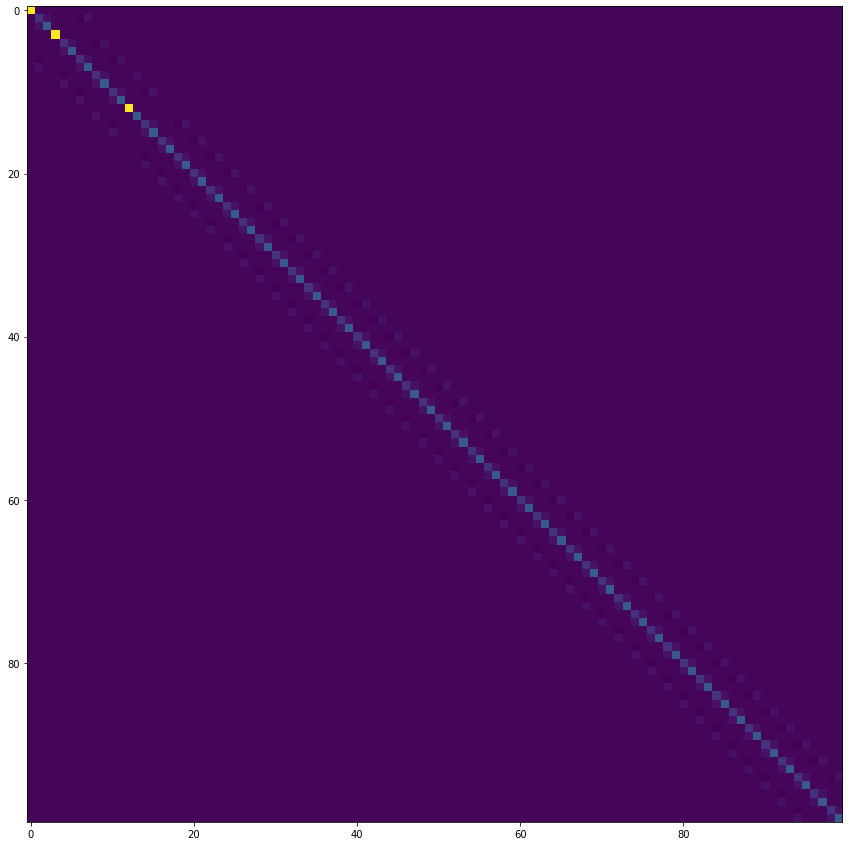

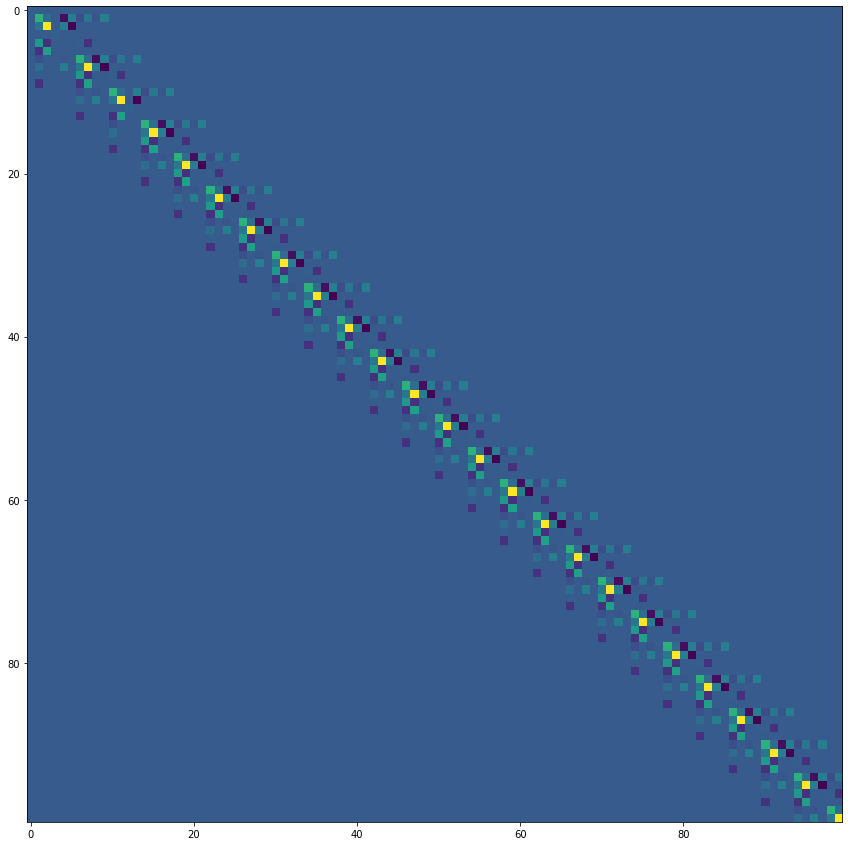

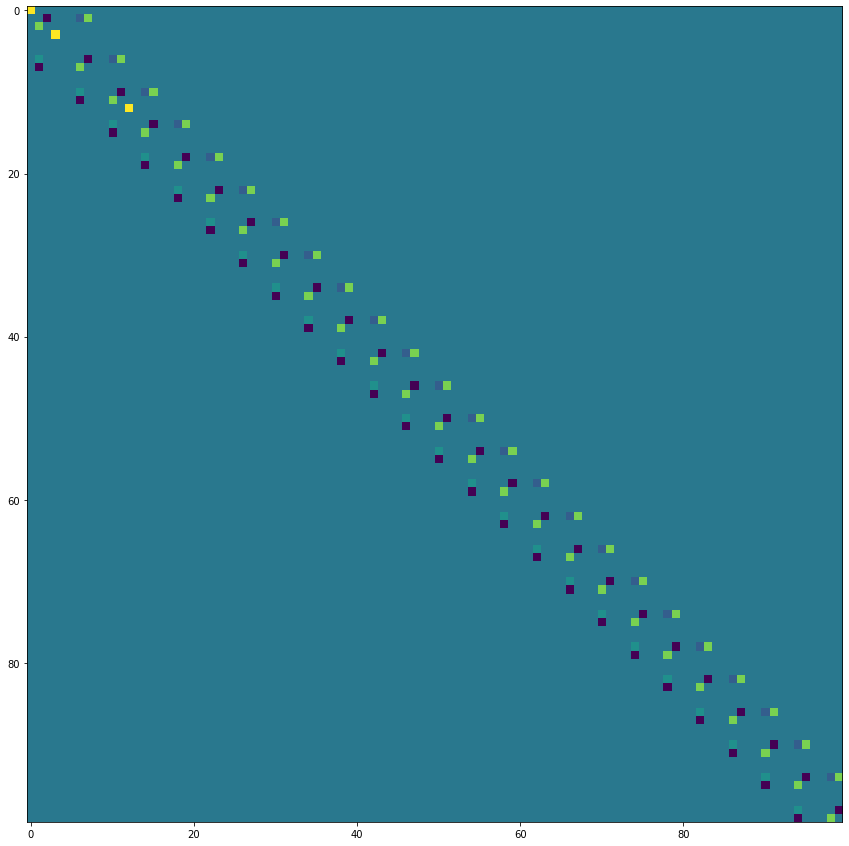

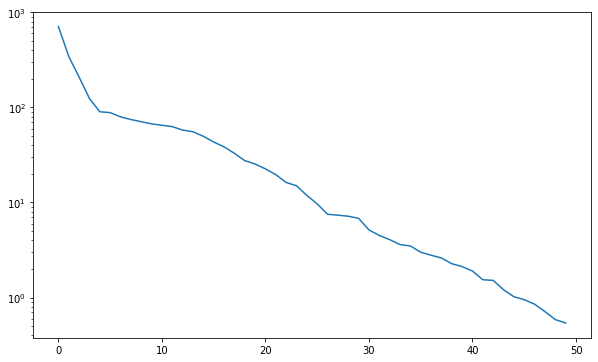

0.9901817112492748
36
(1602, 35)


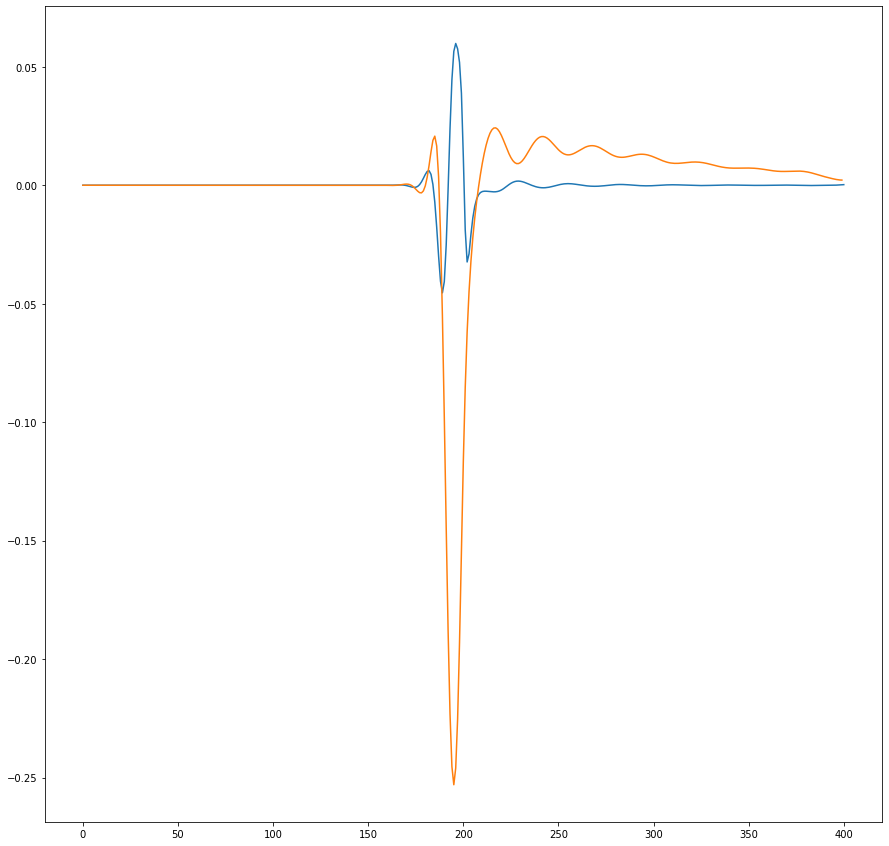

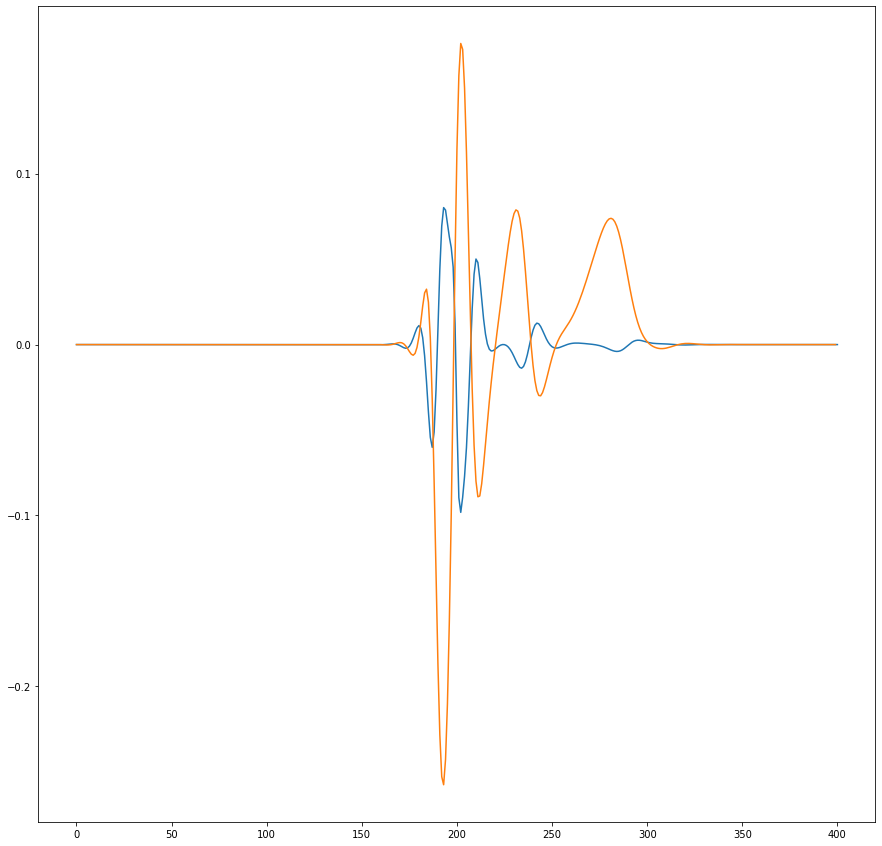

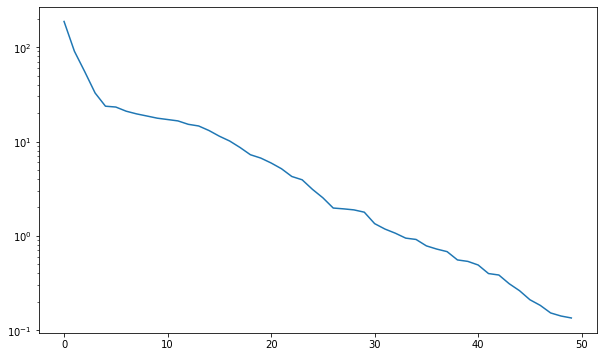

0.990593571613641
36
(1602, 35)


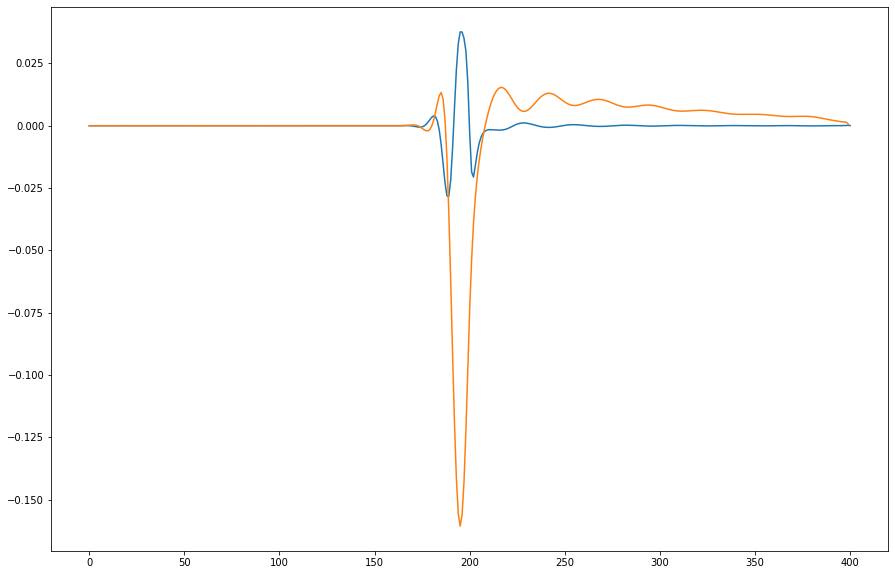

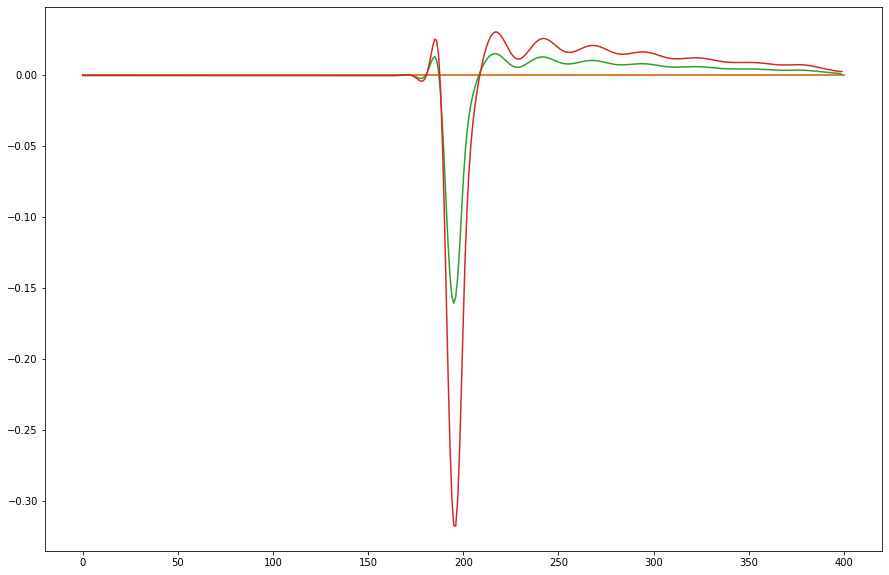

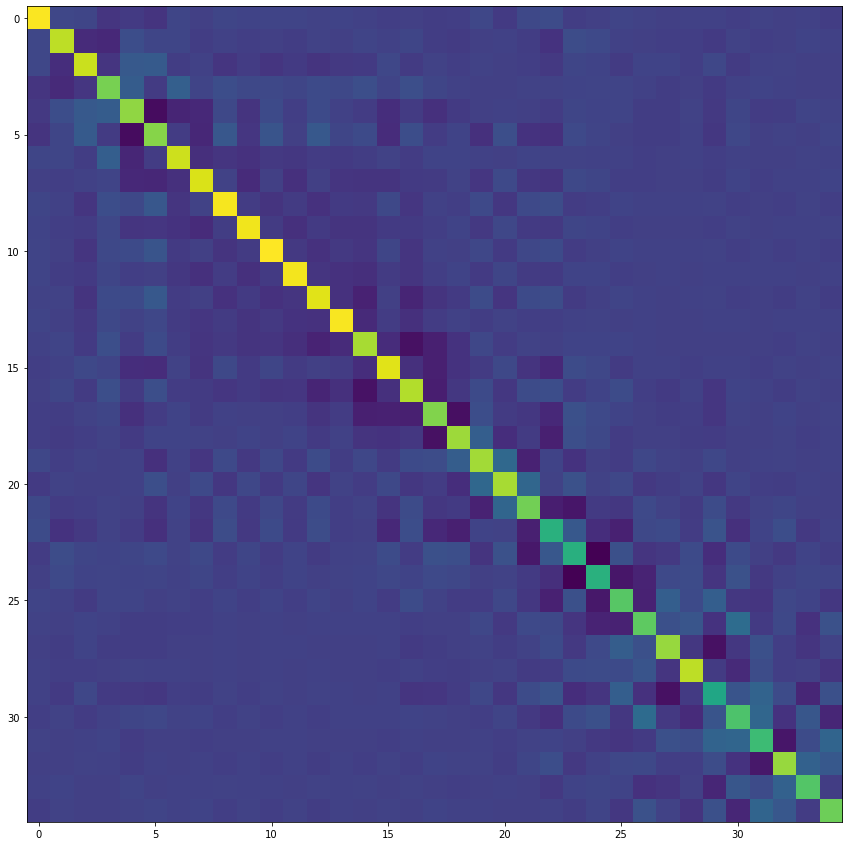

N( 0 ,l,m)


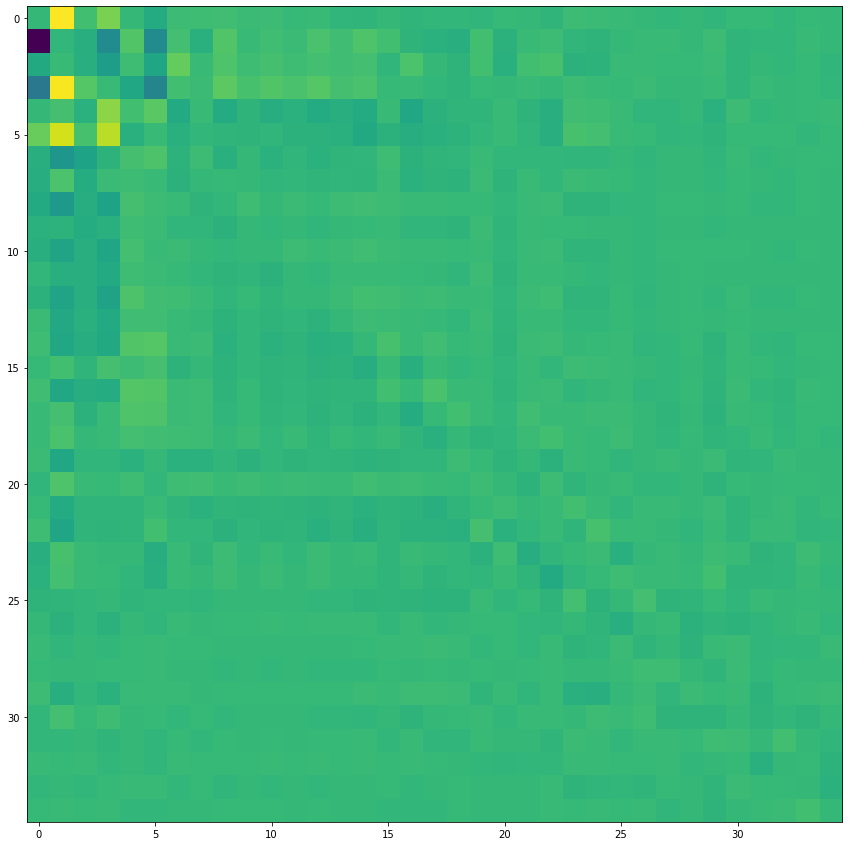

N( 1 ,l,m)


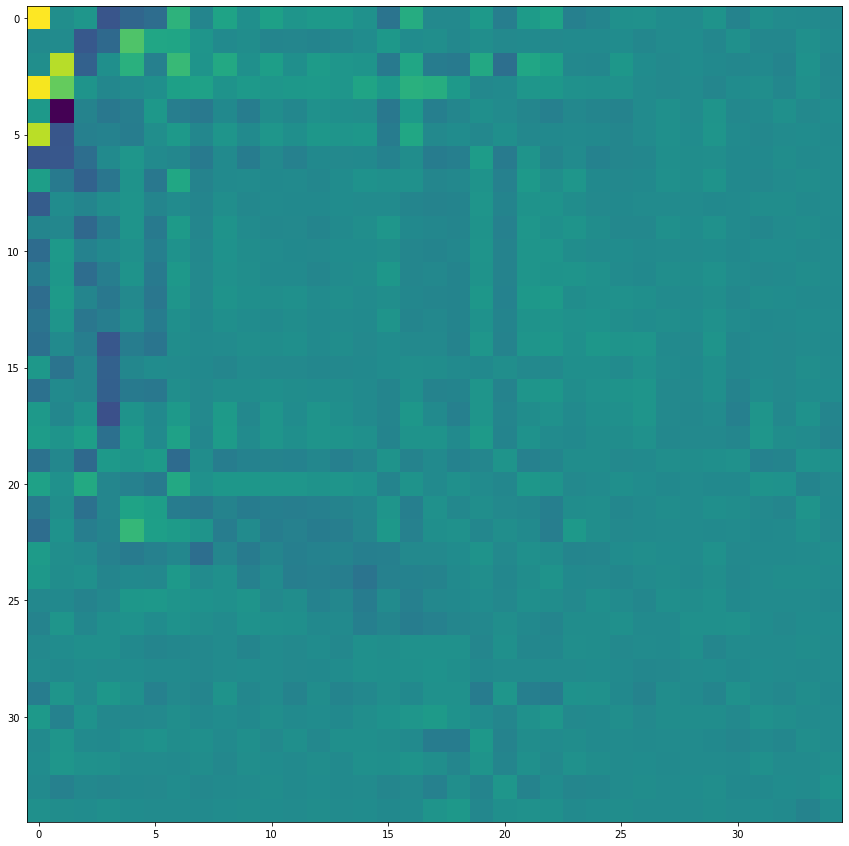

N( 2 ,l,m)


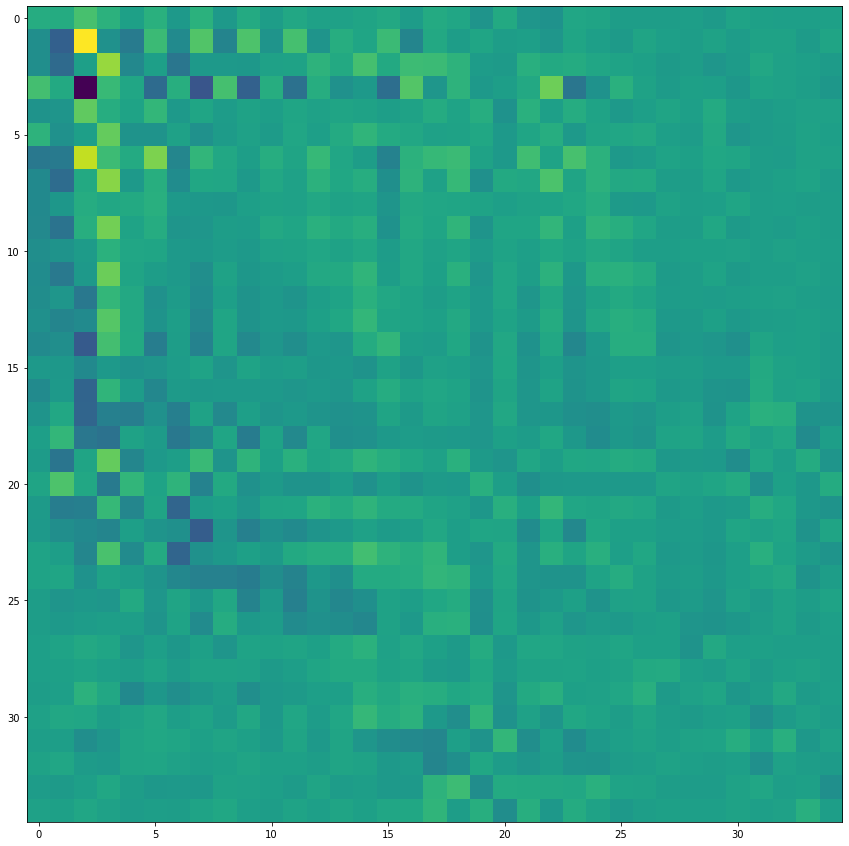

N( 3 ,l,m)


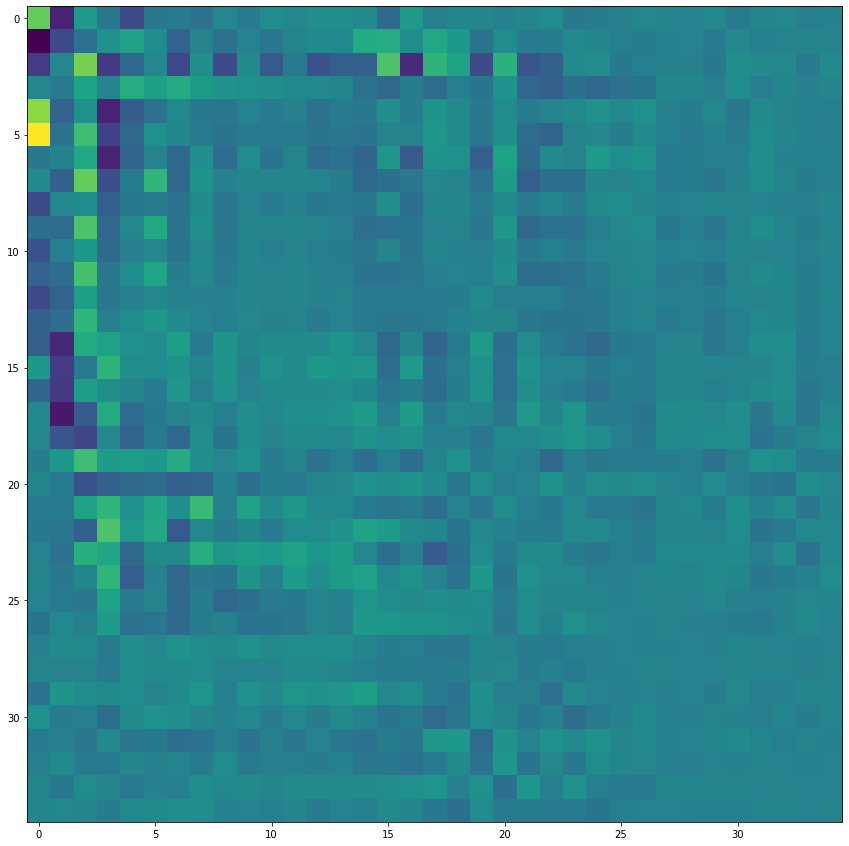

N( 4 ,l,m)


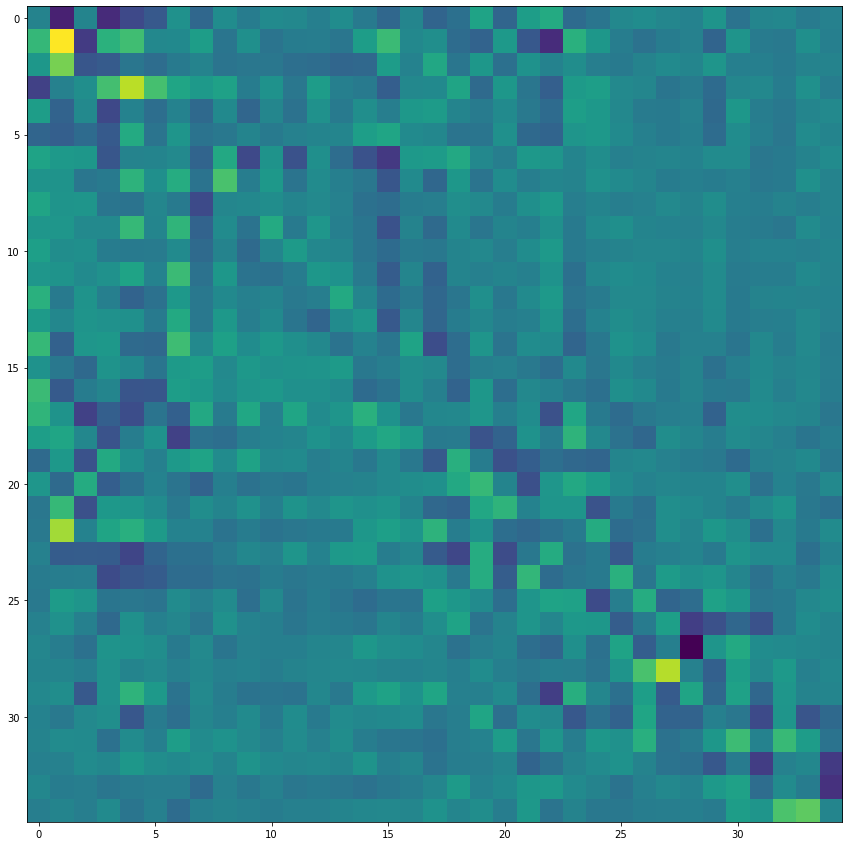

N( 5 ,l,m)


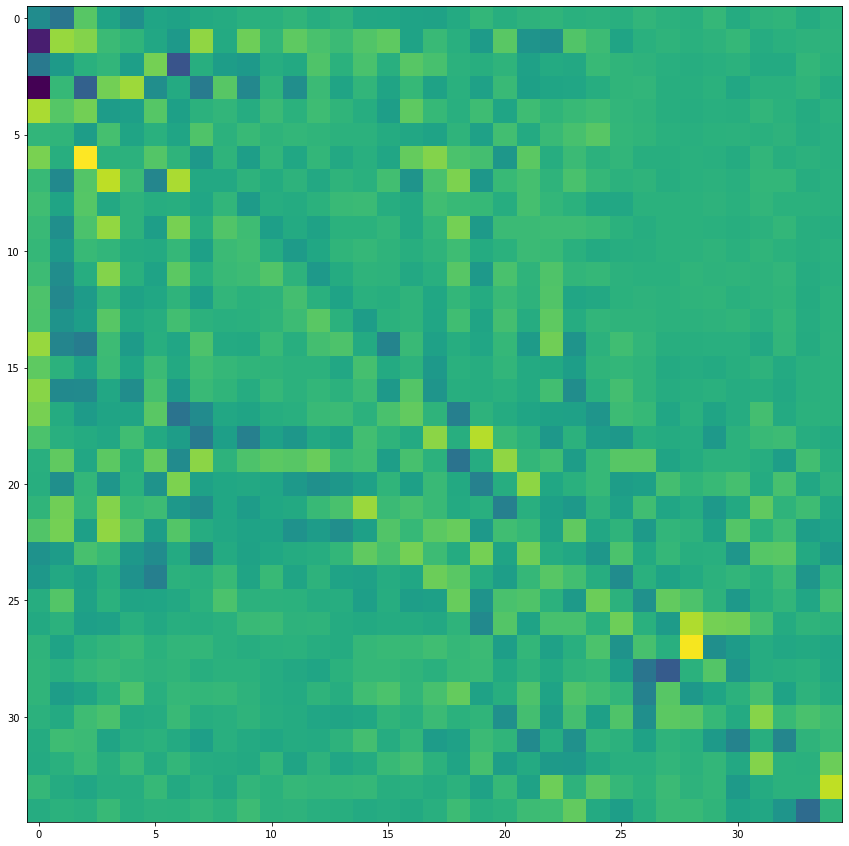

N( 6 ,l,m)


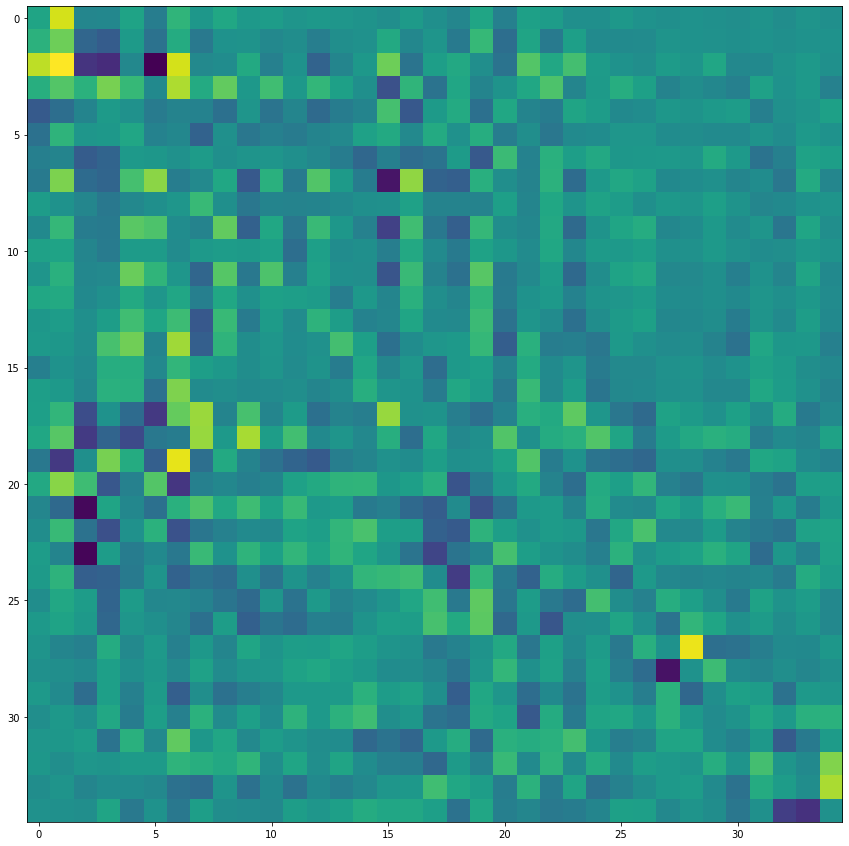

N( 7 ,l,m)


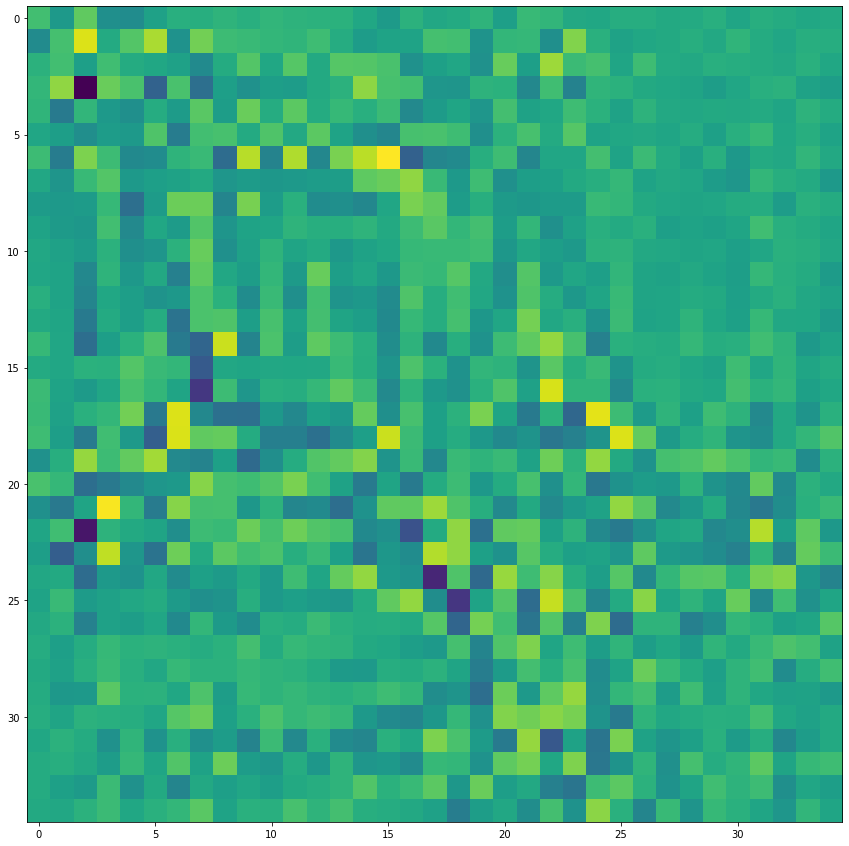

N( 8 ,l,m)


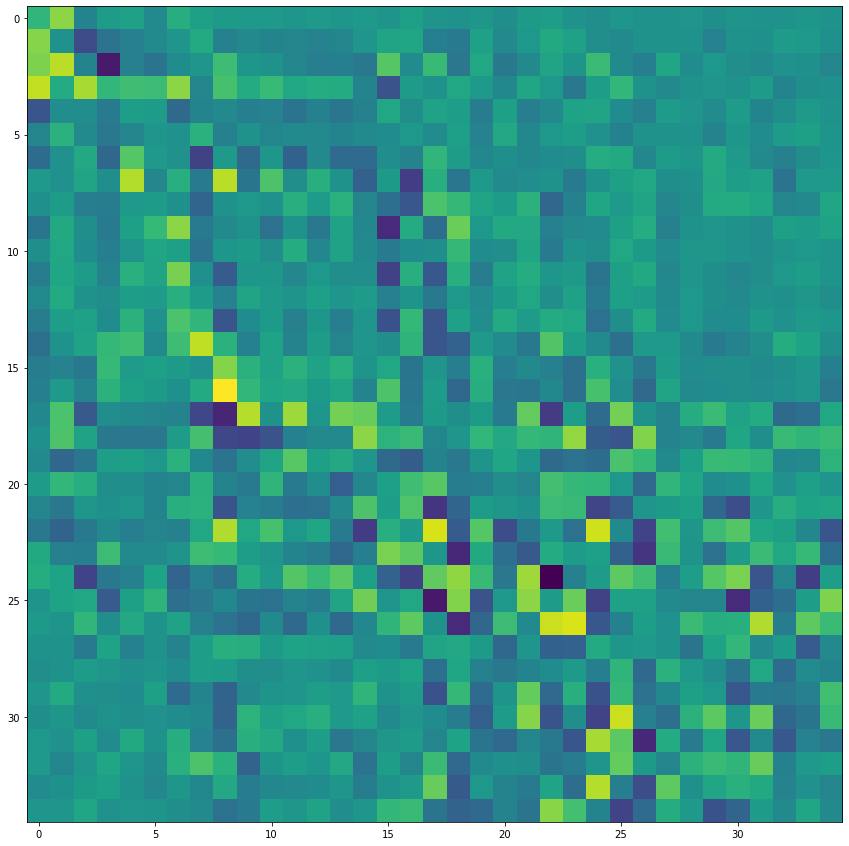

N( 9 ,l,m)


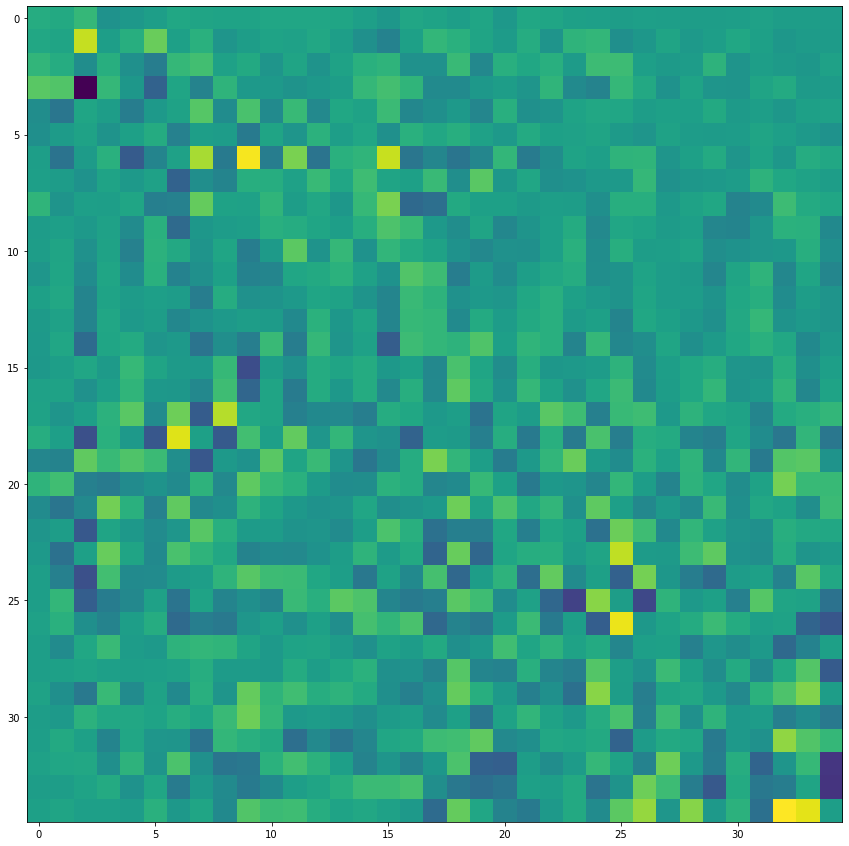

N( 10 ,l,m)


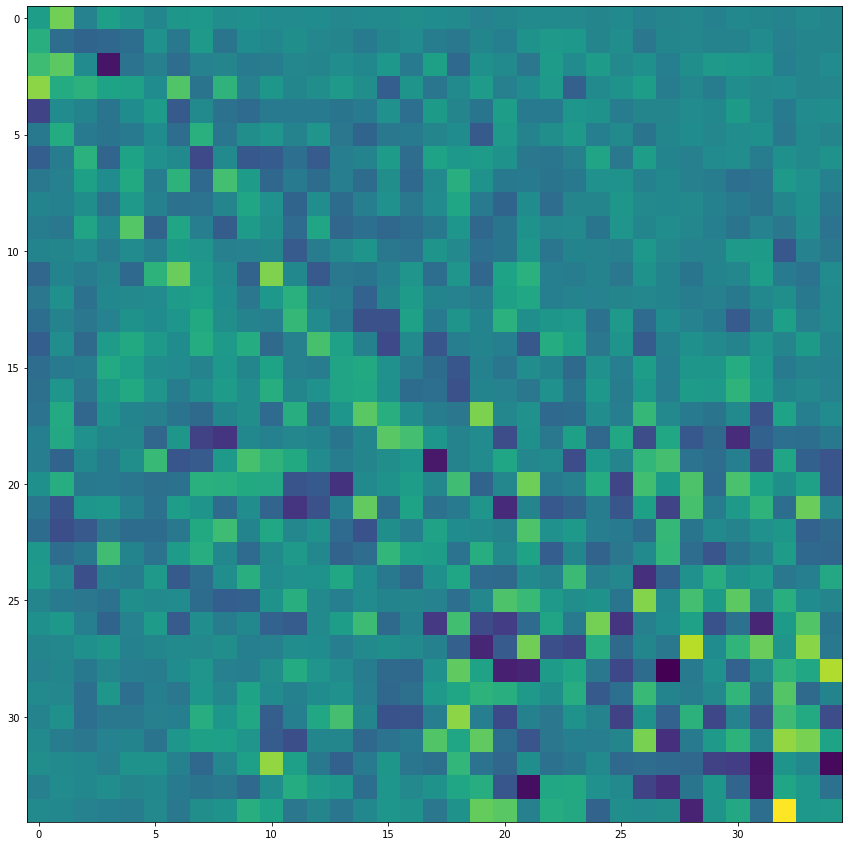

N( 11 ,l,m)


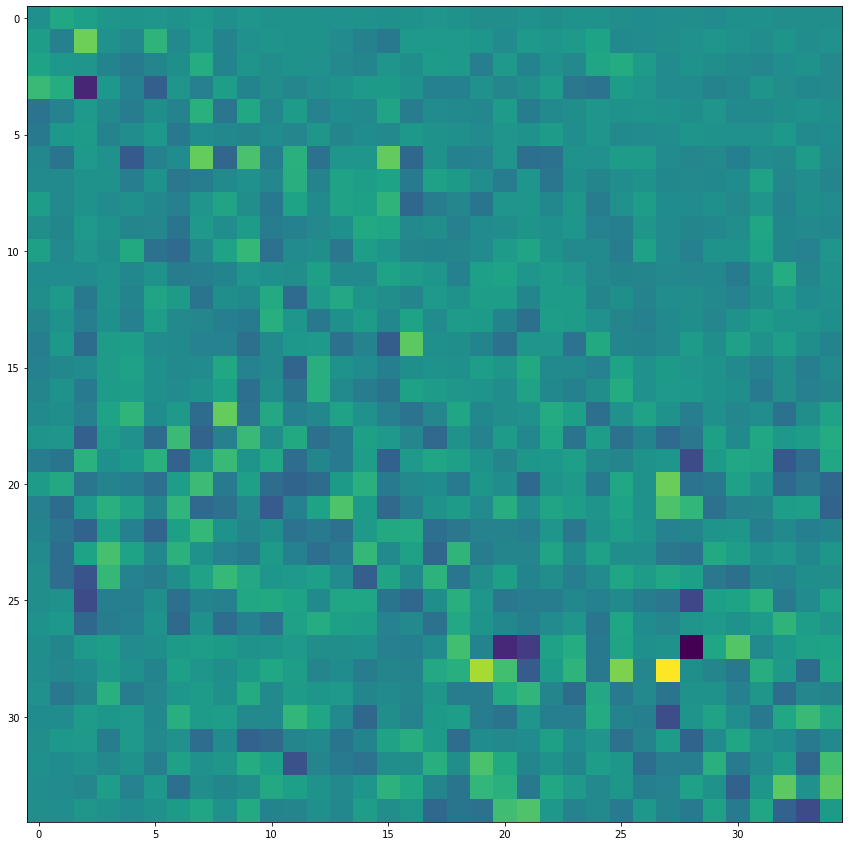

N( 12 ,l,m)


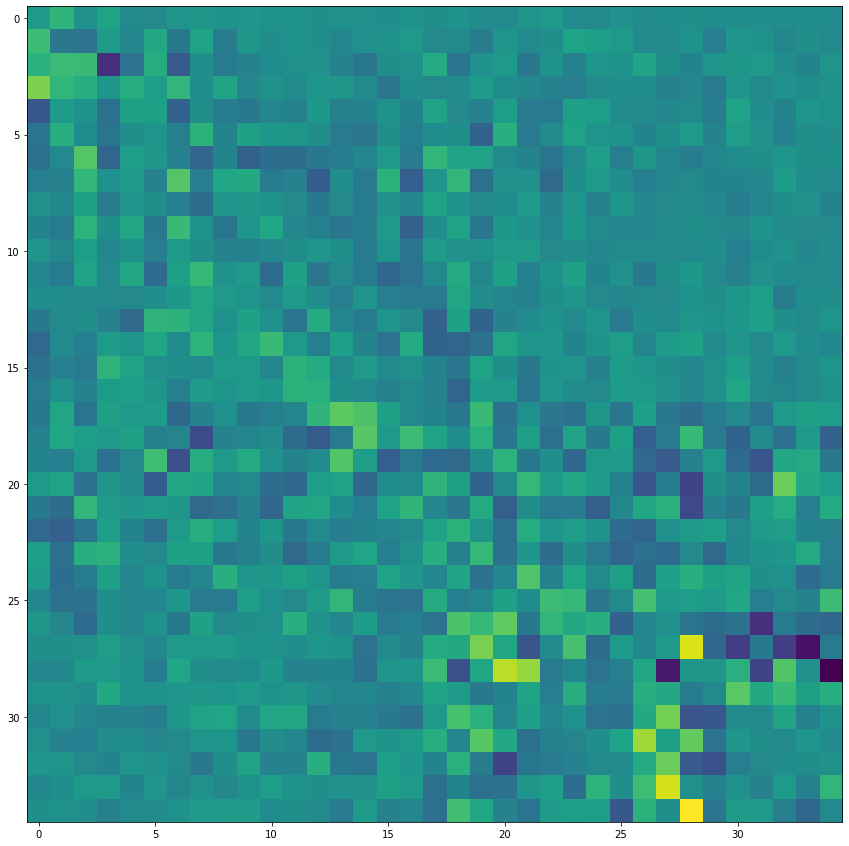

N( 13 ,l,m)


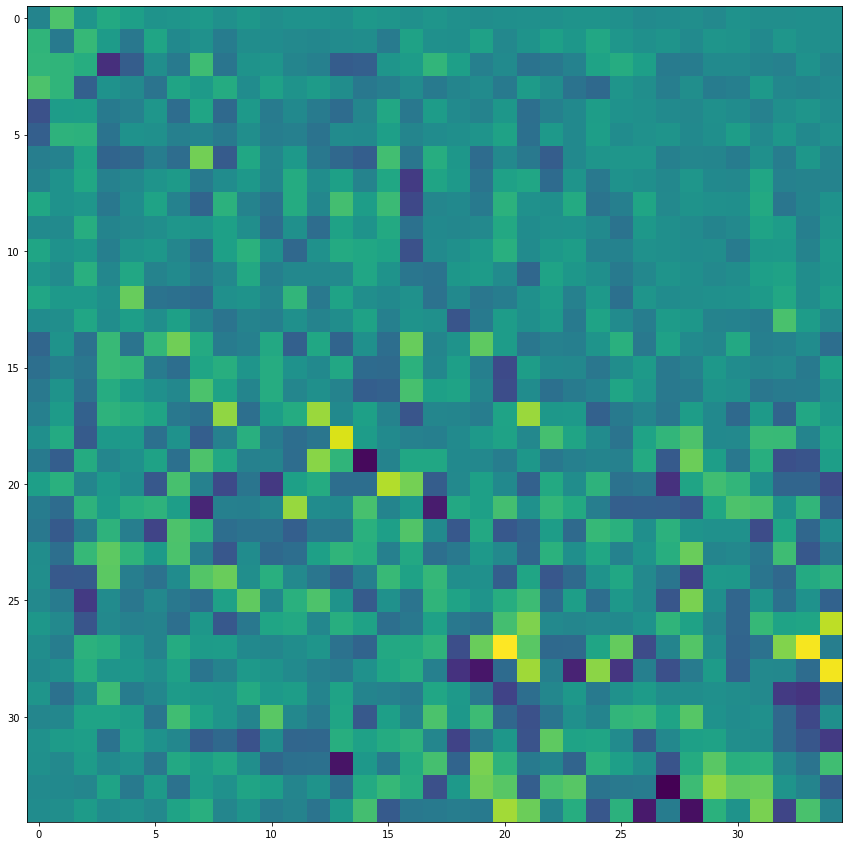

N( 14 ,l,m)


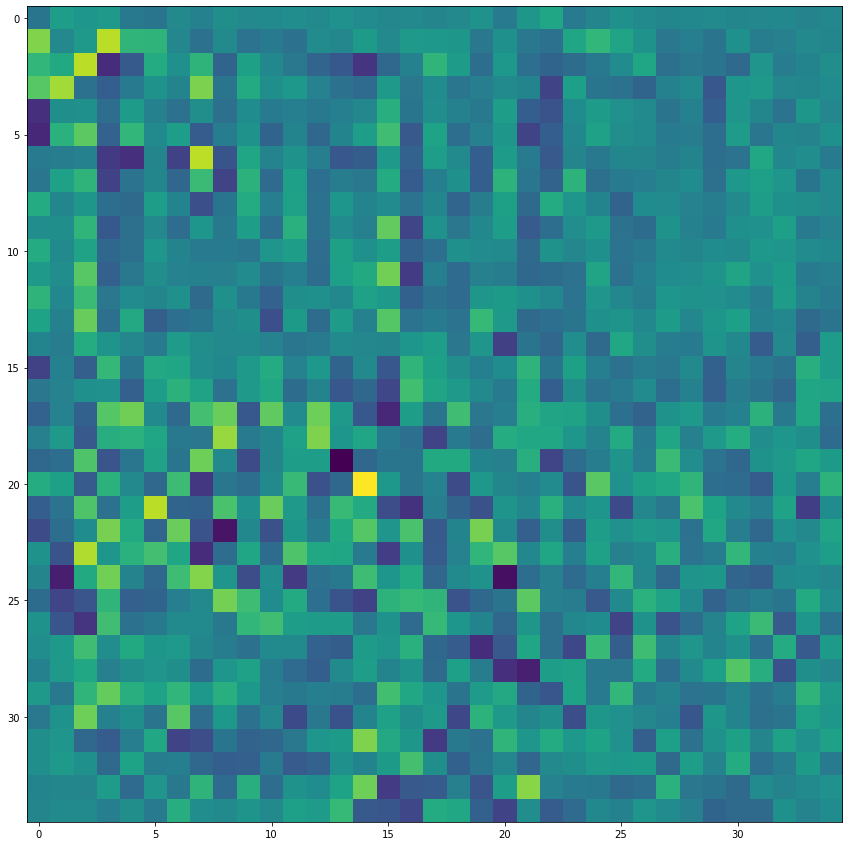

N( 15 ,l,m)


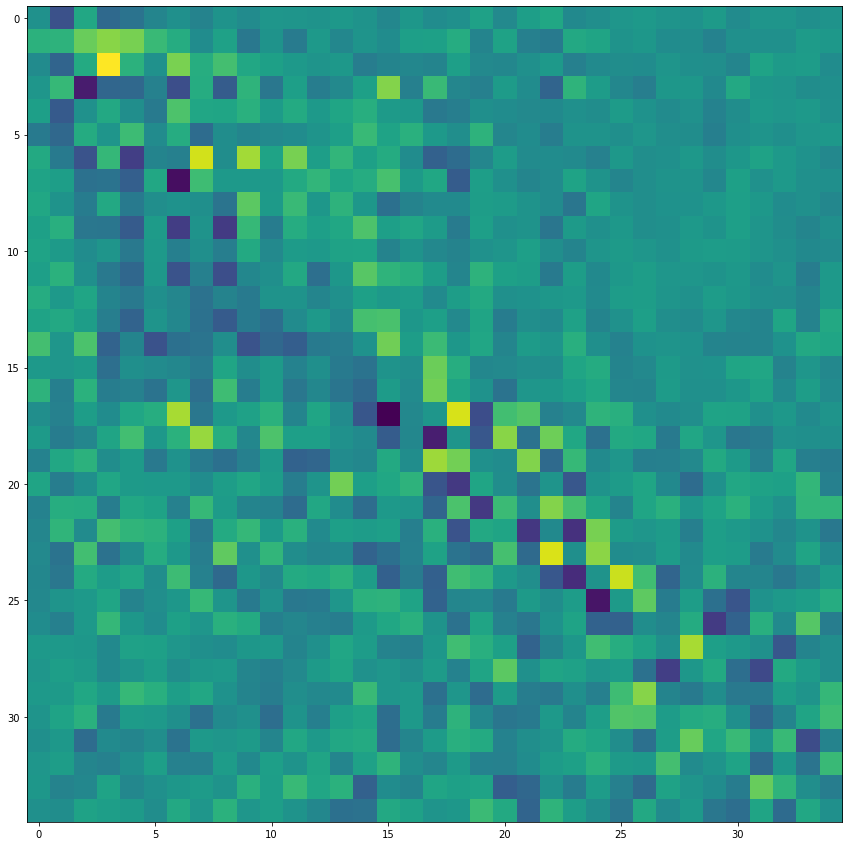

N( 16 ,l,m)


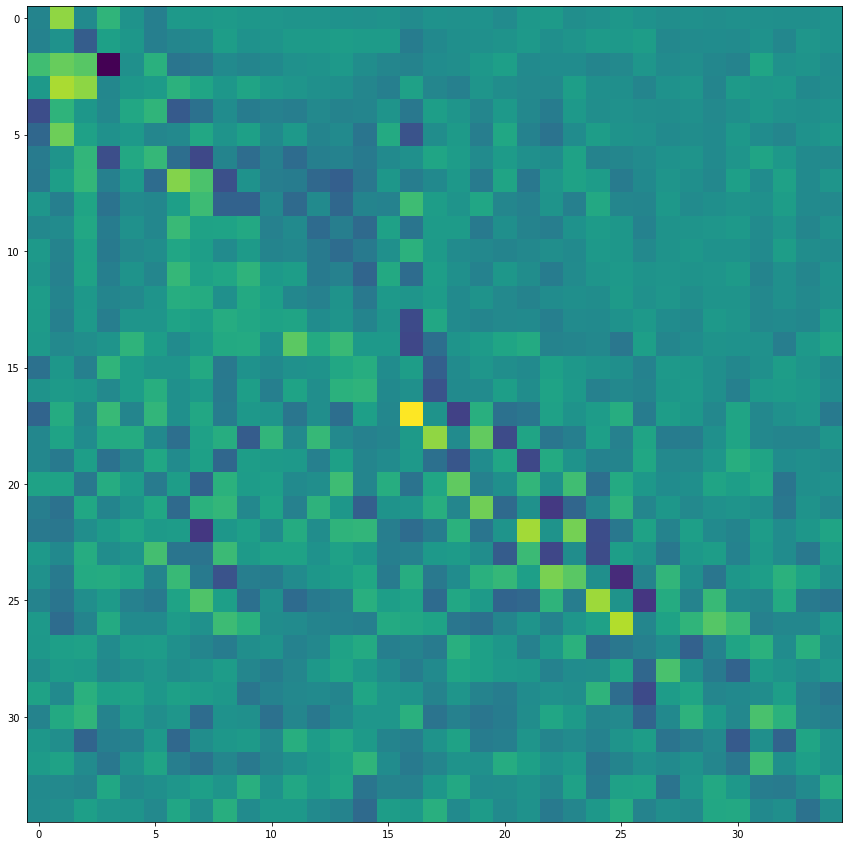

N( 17 ,l,m)


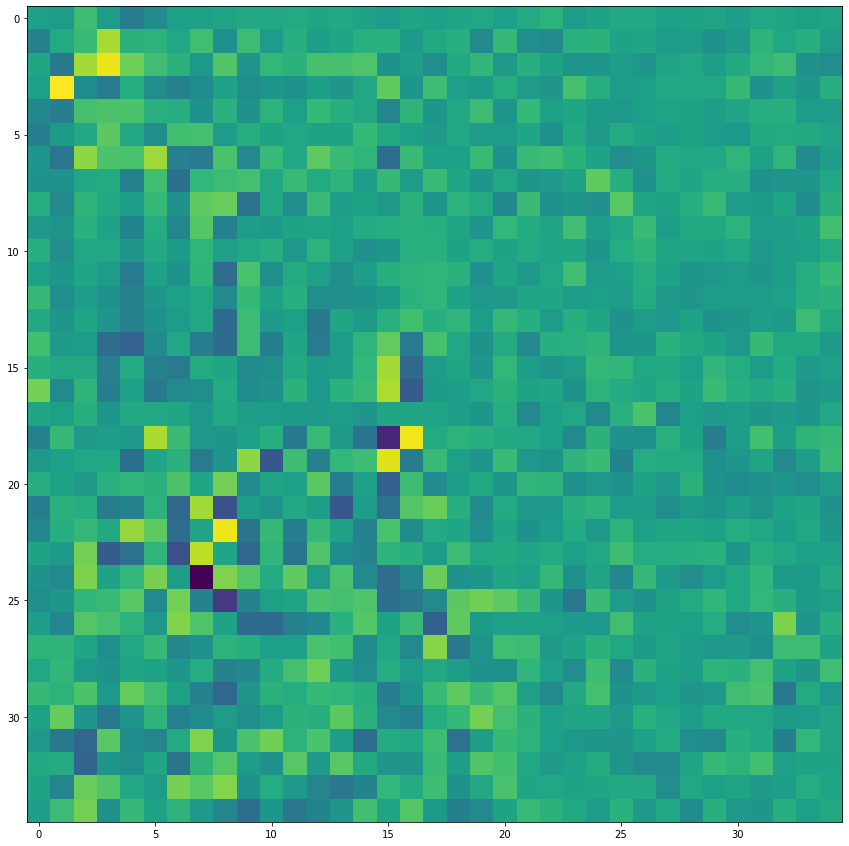

N( 18 ,l,m)


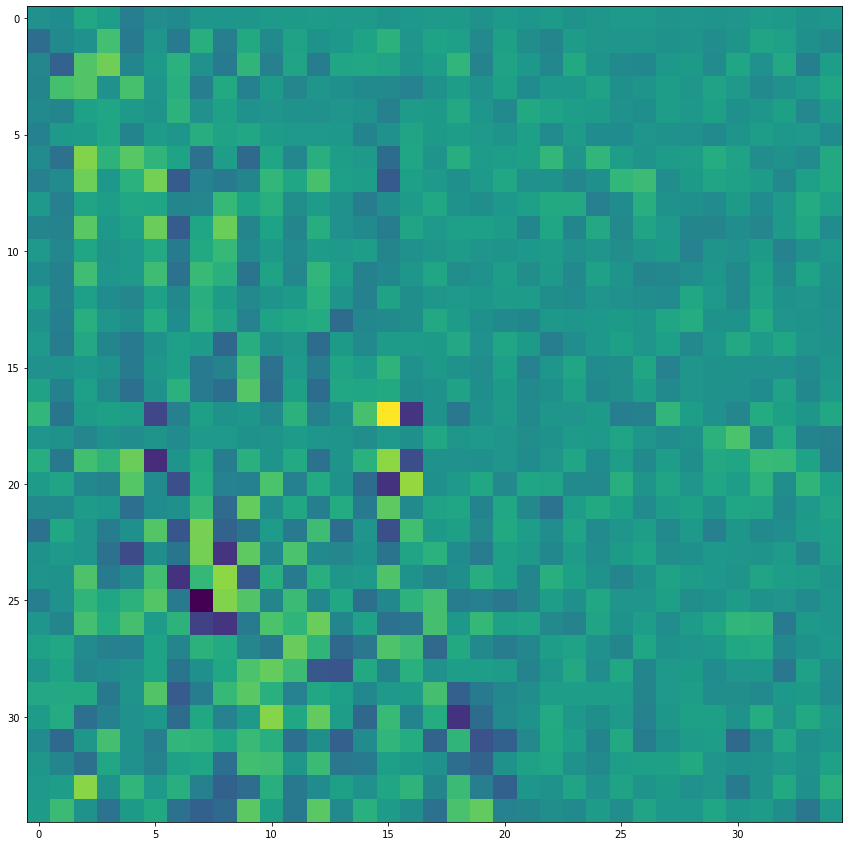

N( 19 ,l,m)


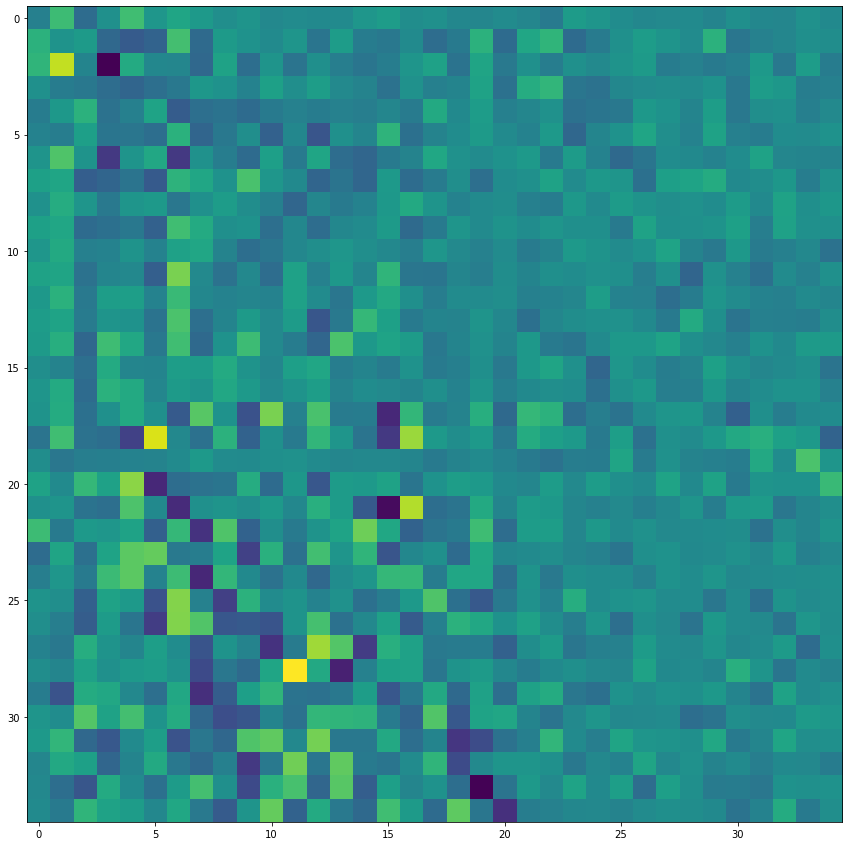

N( 20 ,l,m)


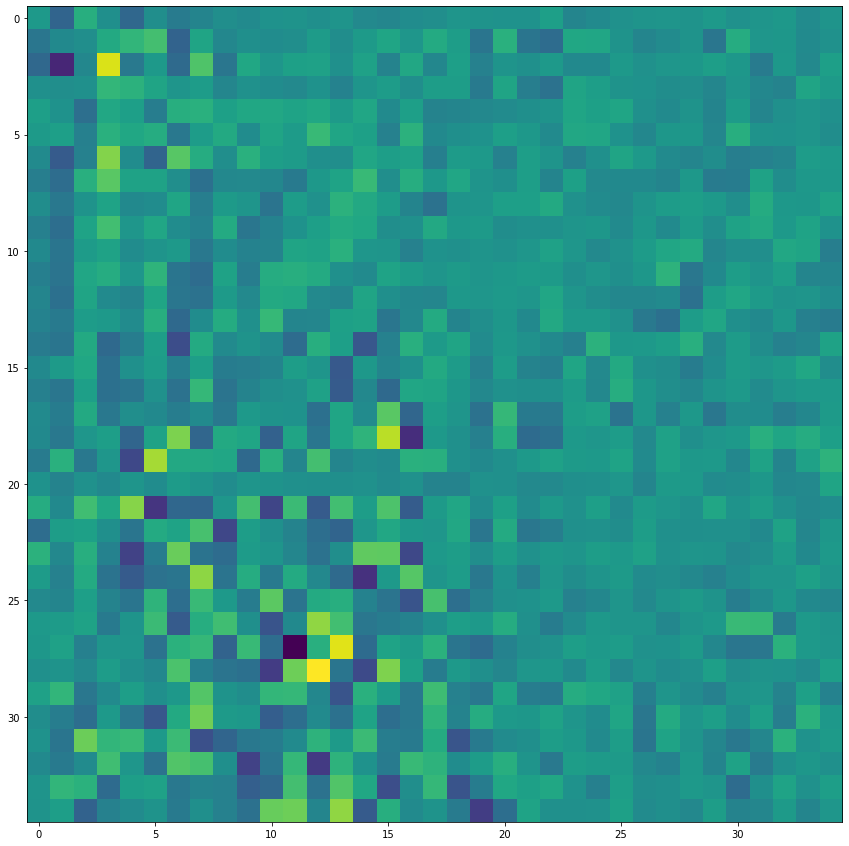

N( 21 ,l,m)


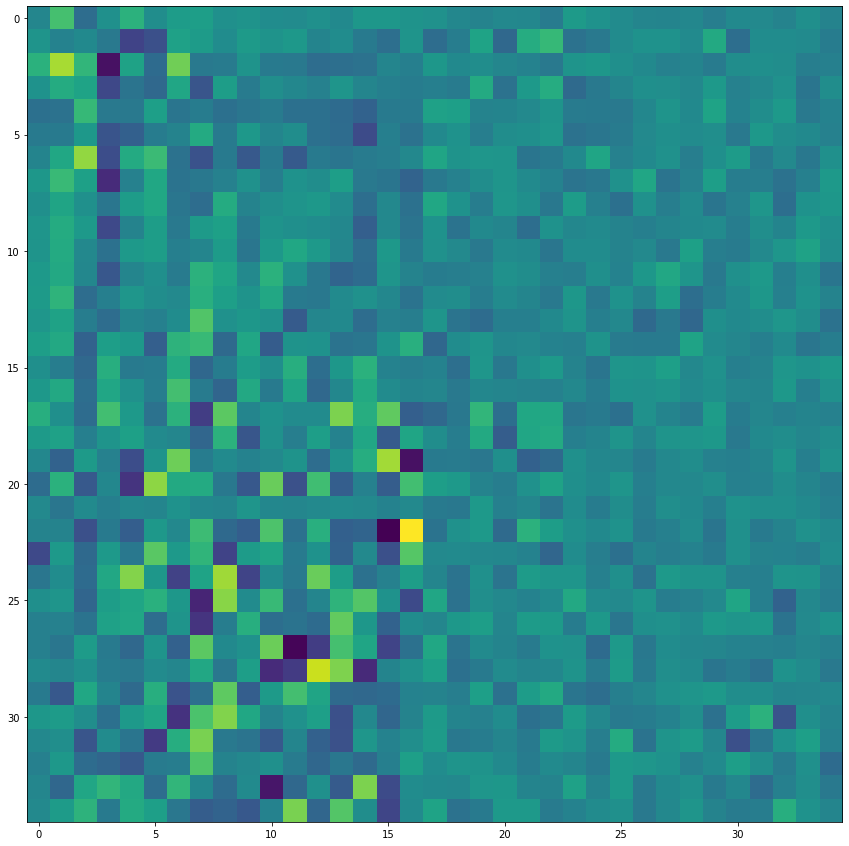

N( 22 ,l,m)


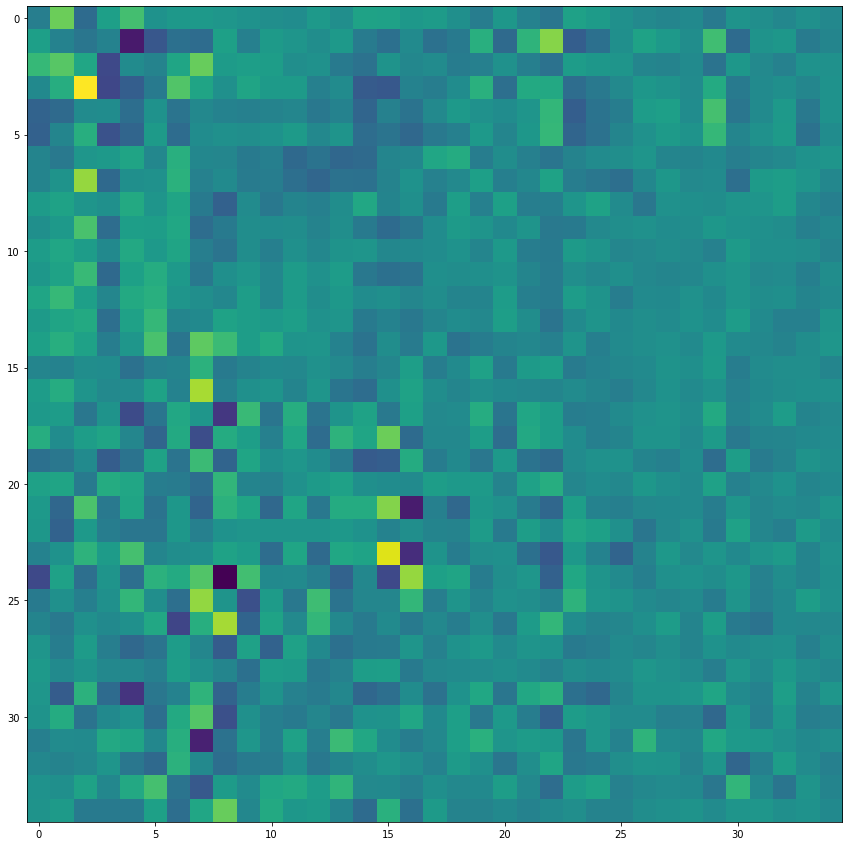

N( 23 ,l,m)


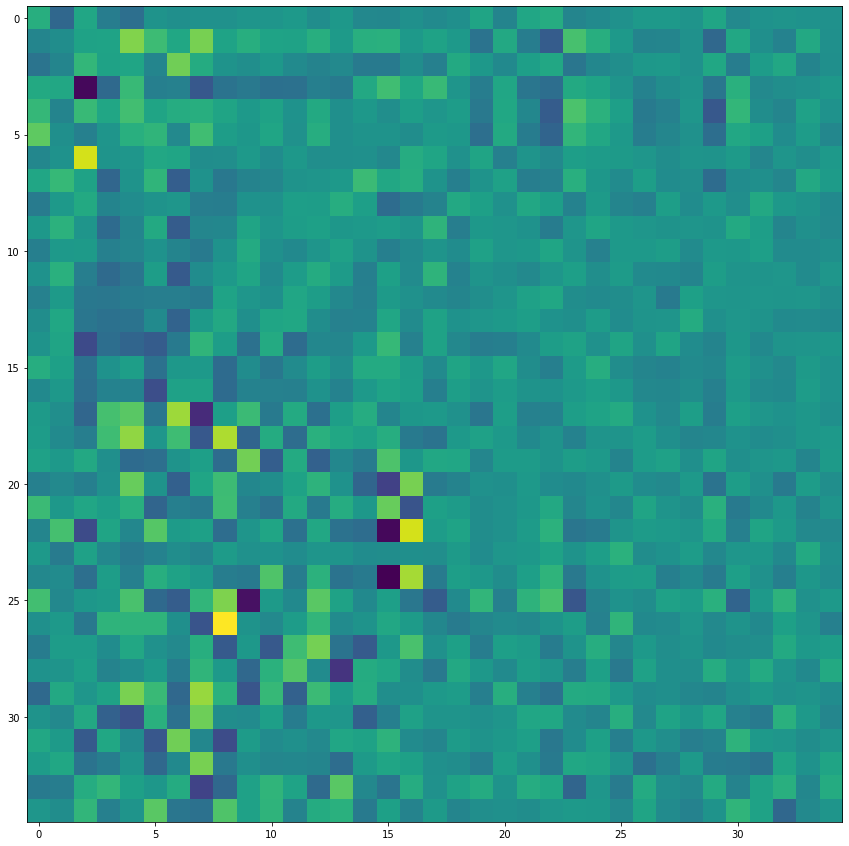

N( 24 ,l,m)


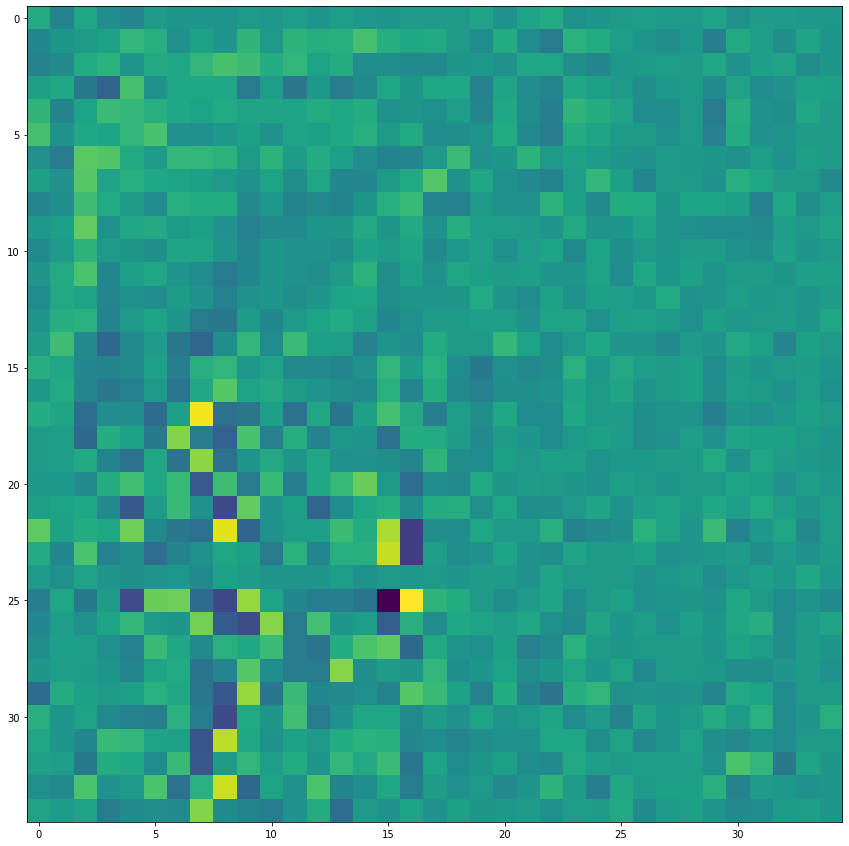

N( 25 ,l,m)


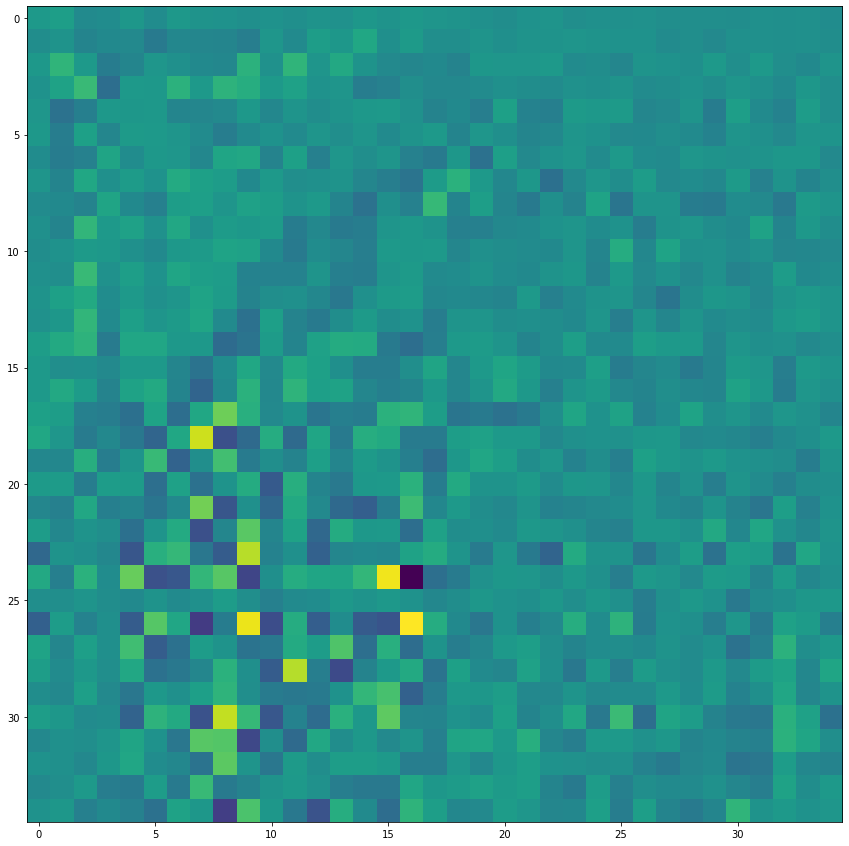

N( 26 ,l,m)


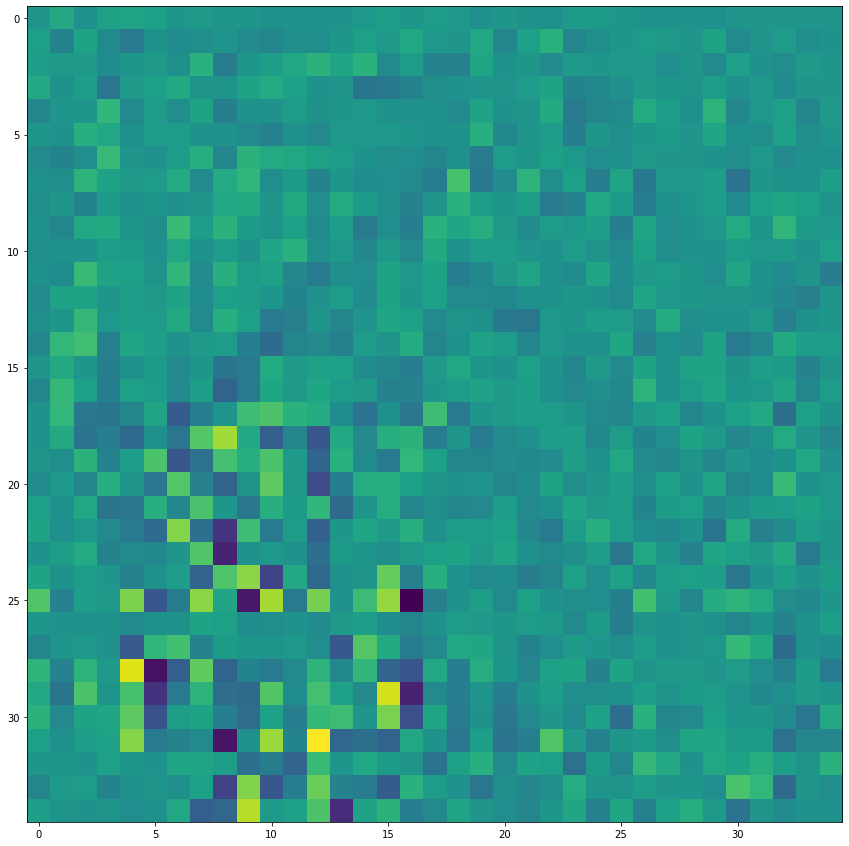

N( 27 ,l,m)


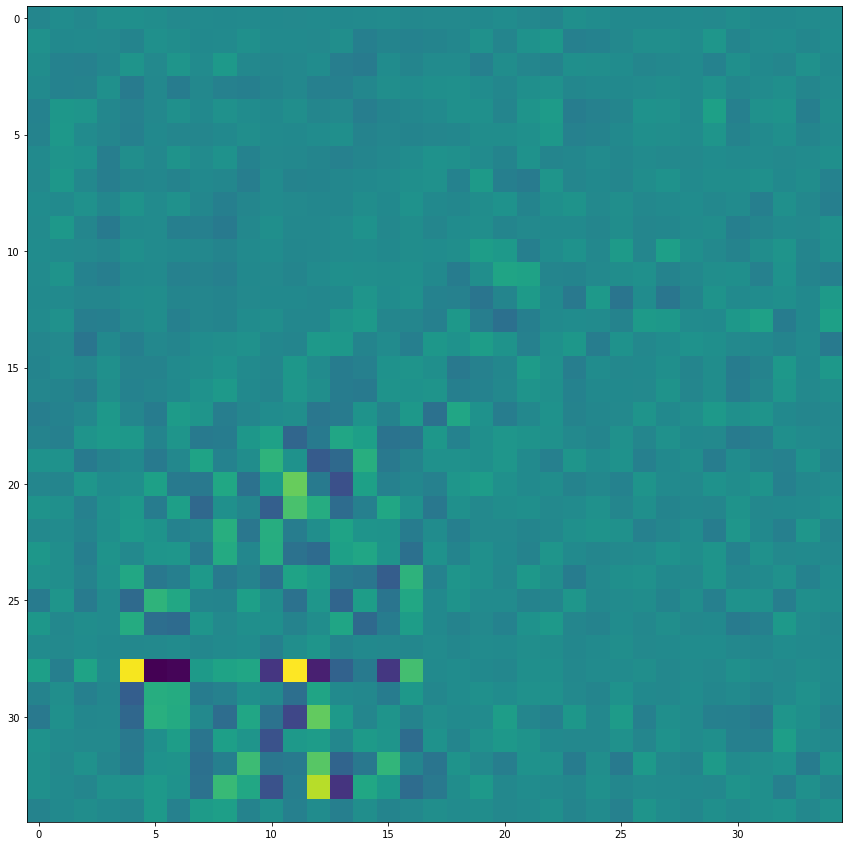

N( 28 ,l,m)


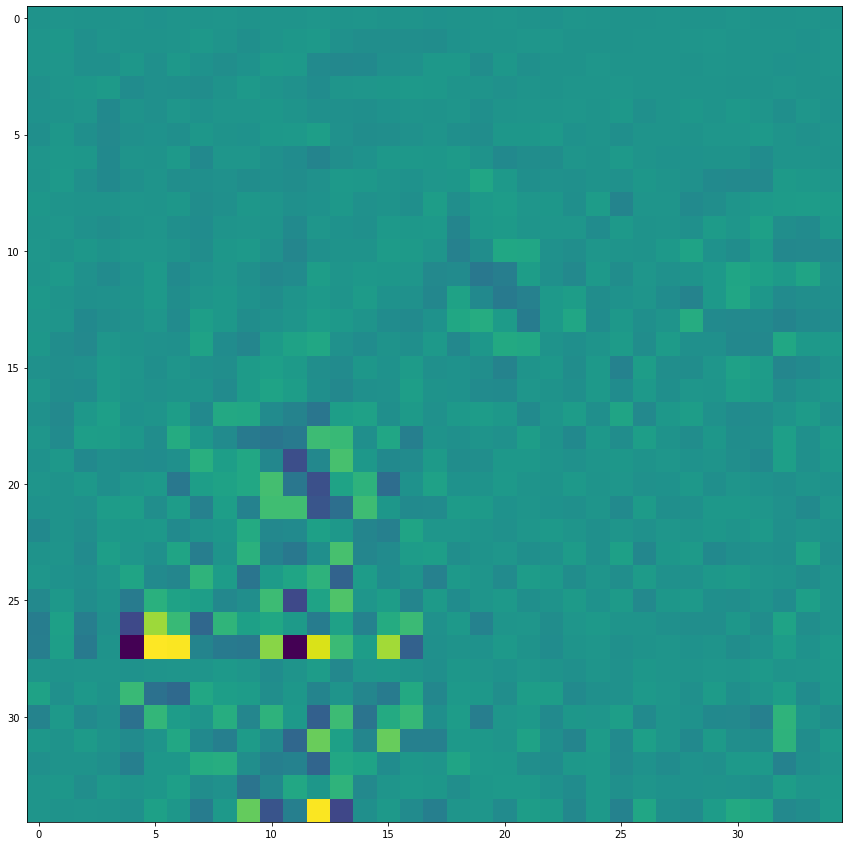

N( 29 ,l,m)


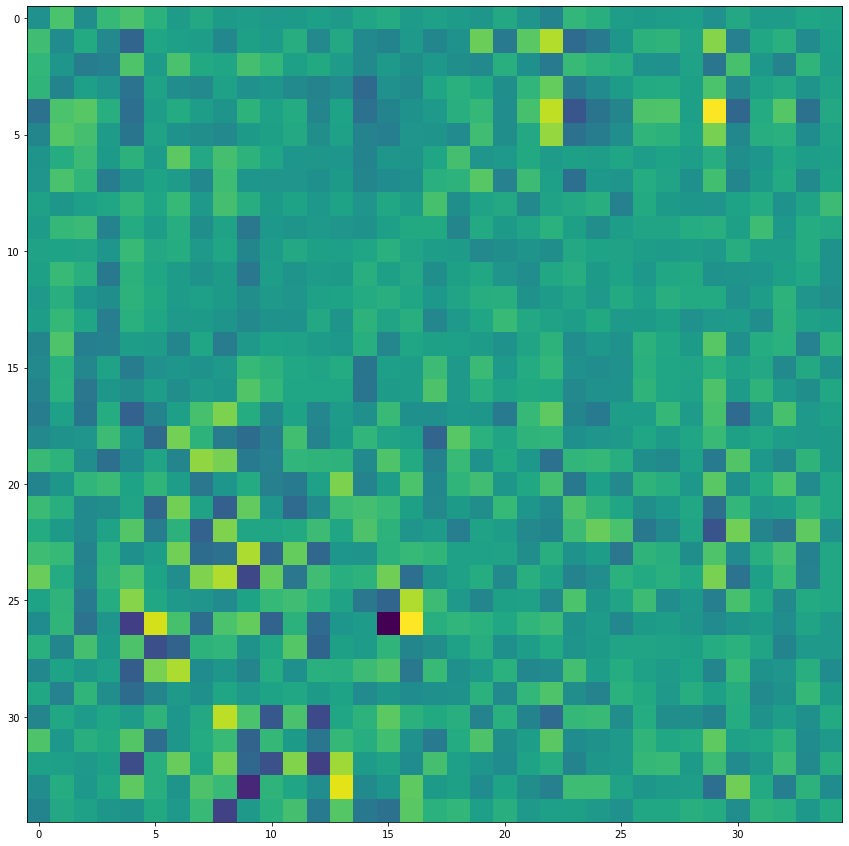

N( 30 ,l,m)


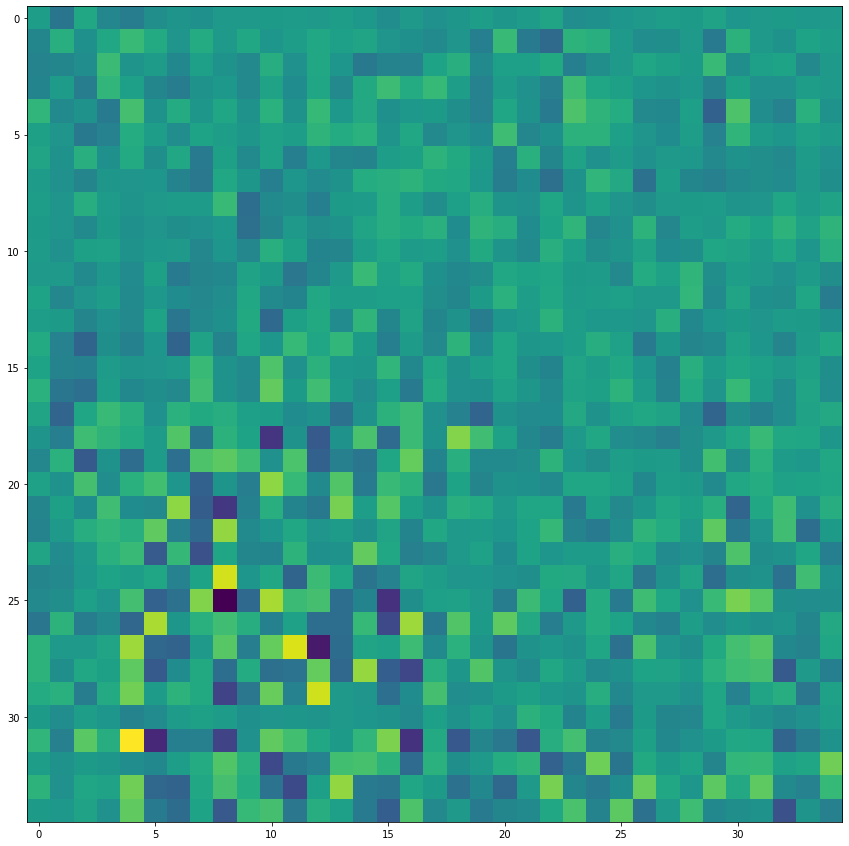

N( 31 ,l,m)


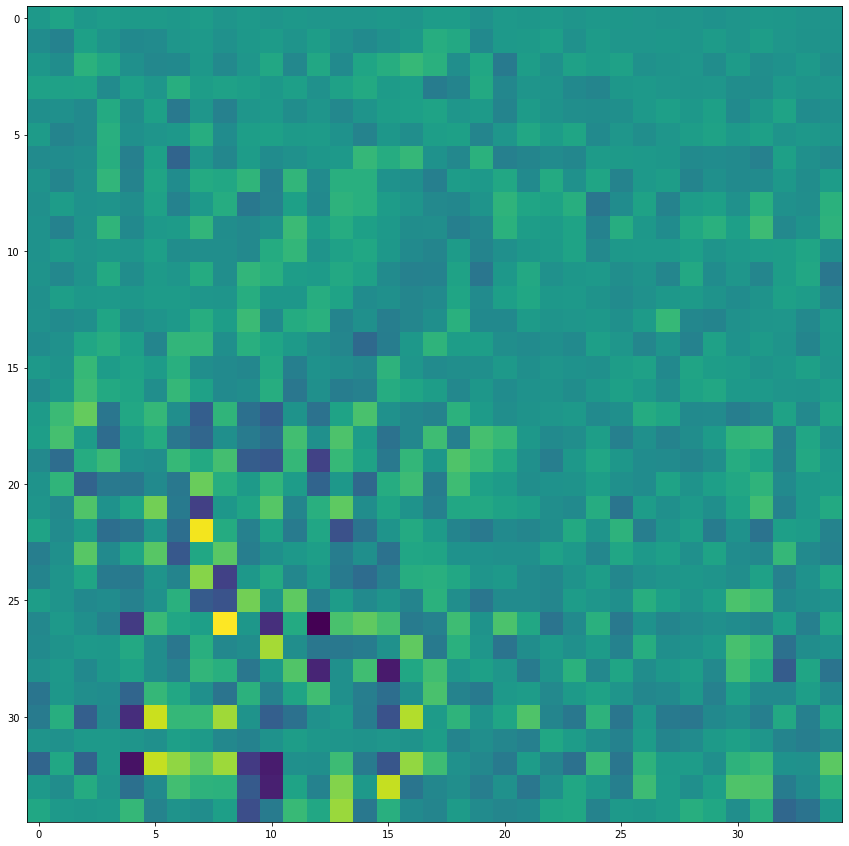

N( 32 ,l,m)


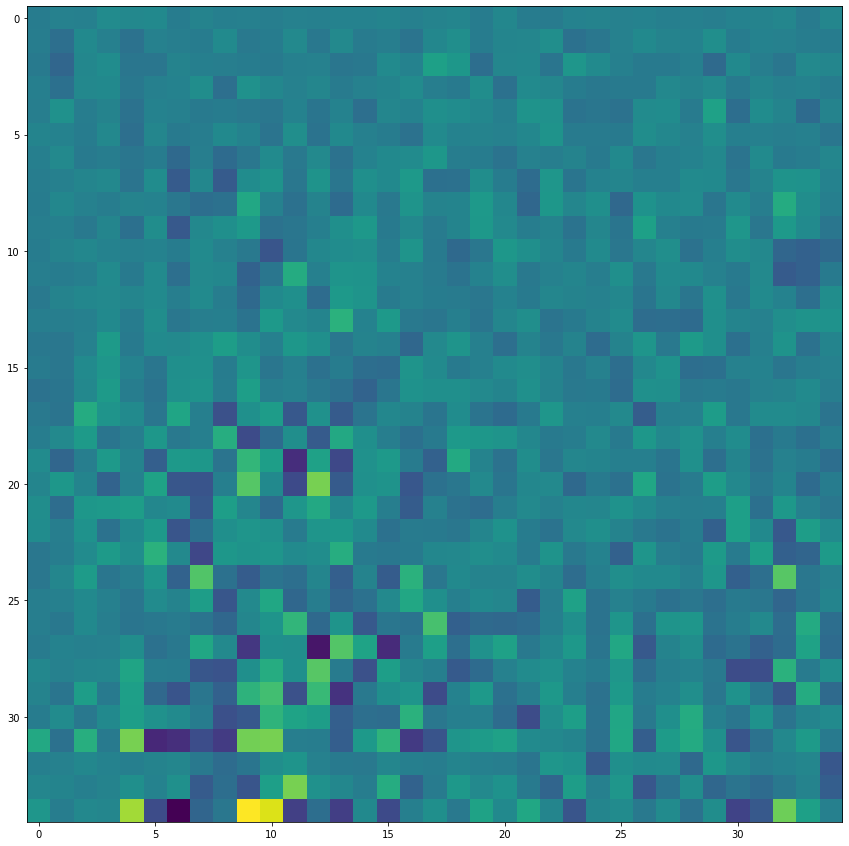

N( 33 ,l,m)


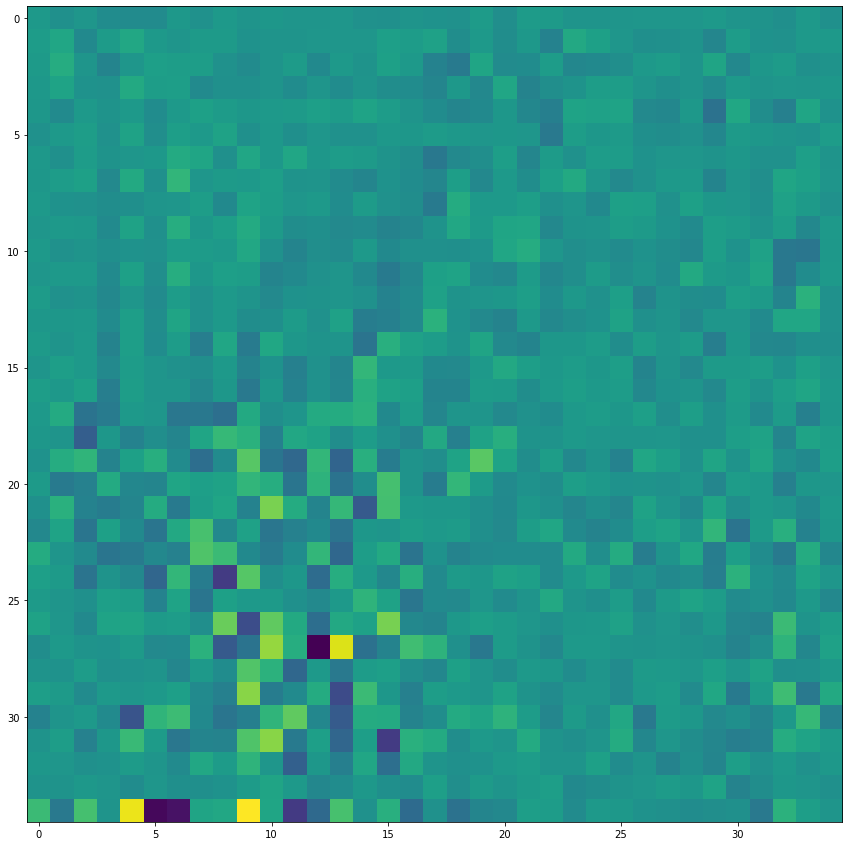

N( 34 ,l,m)


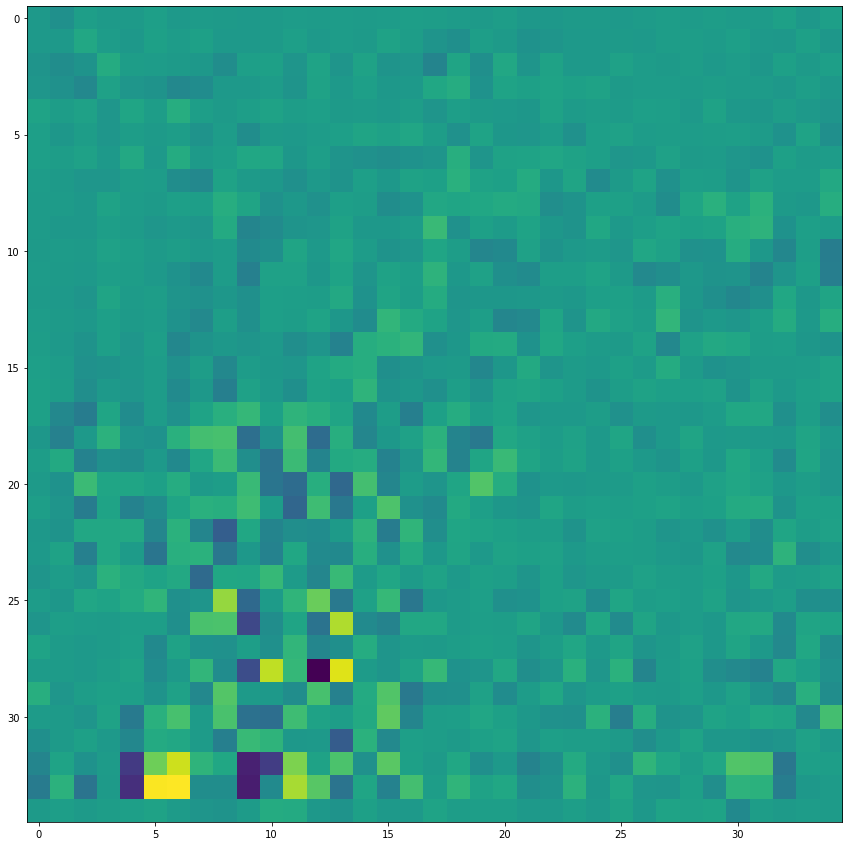

Solving PDE:   0%|          | 0/25000 [00:00<?, ?it/s]

{'block_size': 1.0, 'nz_allocated': 12804.0, 'nz_used': 12804.0, 'nz_unneeded': 0.0, 'memory': 0.0, 'assemblies': 1.0, 'mallocs': 0.0, 'fill_ratio_given': 0.0, 'fill_ratio_needed': 0.0, 'factor_mallocs': 0.0}
False
(1602, 1602)


KeyboardInterrupt: ignored

In [48]:
x = simulation_KS_expli_red(traj_1, t = 250, dt = 0.01, N = 400, order = 2, gamma = 1, mu_factor = 1)

In [ ]:
def print_result_image(x):

    plt.imshow(x[::2,:])
    plt.show()

y = simulation_KS(t = 4, dt = 0.02, N = 200, order = 2, nu = 0.005)

print_result_image(y)

In [ ]:

# #----------------------------- Variational form ------------------------------- 
# V_element = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
# Q_element = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)

# """Run standard FEniCSx formulation using a mixed function space."""
# # Function spaces
# W_element = ufl.MixedElement(V_element, Q_element)
# W = dolfinx.fem.FunctionSpace(mesh, W_element)

# # Test and trial functions
# vq = ufl.TestFunction(W)
# (v, q) = ufl.split(vq)
# dup = ufl.TrialFunction(W)
# up = dolfinx.fem.Function(W) # since the problem is nonlinear, a "Function" js created to store solution
# (u, p) = ufl.split(up)

# # Variational forms (Be careful with the use of grad() or nabla_grad(), one is
# # dui/dxj, the other duj/dxi, see documentation)
# Re = 40.
# nu = 1. / Re
# F = ( nu * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
#       + nu * (ufl.div(u)) * (ufl.div(v)) * ufl.dx
#       + ufl.inner(ufl.grad(u) * u, v) * ufl.dx
#       - ufl.inner(p, ufl.div(v)) * ufl.dx
#       + ufl.inner(ufl.div(u), q) * ufl.dx)
#       # + nu * (ufl.Dx(u[0],1) + ufl.Dx(u[1],0)) * (ufl.Dx(v[0],1) + ufl.Dx(v[1],0)) * ufl.dx

# # SUPG 
# d = ufl.CellDiameter(mesh)
# vnorm = ufl.sqrt(ufl.inner(u, u))
# ReT = 0.5 * vnorm * d * Re

# tau_SUPG_1 = d * d * Re / 12.
# tau_SUPG_2 = 0.5 * d / vnorm

# tau_SUPG = ufl.conditional(ufl.gt(ReT, 3.0), tau_SUPG_2, tau_SUPG_1) # if ReT > 3, use tau1, else, tau2 (as done by Olivier)

# # Strong formulation:
# S = 2.*nu*ufl.sym(ufl.grad(u)) 
# res_strong = ufl.dot(u, ufl.grad(u)) - ufl.div(S) + ufl.grad(p)

# F_SUPG = ufl.inner(tau_SUPG * res_strong, ufl.dot(ufl.grad(v),u)) * ufl.dx 
# F = F + F_SUPG
    
# # Linearization of the varf
# J = ufl.derivative(F, up, dup)

# #---------------------------- Boundary conditions ----------------------------- 
# wall_bc = dirichlet(W.sub(0), [0,0], obstacle_marker, ft, mesh)
# inlet_bc = dirichlet(W.sub(0), [1,0], inlet_marker, ft, mesh)
# side_bc = dirichlet(W.sub(0), [1,0], side_marker, ft, mesh)
# bc = [inlet_bc,  wall_bc, side_bc]

# #---------------------------- Problem -----------------------------
# # Create problem
# problem = newtonSolver(F, J, up, bc)
# F_vec = dolfinx.fem.petsc.create_vector(problem._F)
# J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

# # Solve
# snes = petsc4py.PETSc.SNES().create(mesh.comm)
# snes.setTolerances(max_it=20)
# snes.getKSP().setType("preonly")
# snes.getKSP().getPC().setType("lu")
# snes.getKSP().getPC().setFactorSolverType("mumps")
# snes.setObjective(problem.obj)
# snes.setFunction(problem.F, F_vec)
# snes.setJacobian(problem.J, J=J_mat, P=None)
# snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.6e"%(it,residual)))
# up_copy = problem.create_snes_solution()
# snes.solve(None, up_copy)
# problem.update_solution(up_copy)  # TODO can this be safely removed?

# (u_f, p_f) = (up.sub(0).collapse(), up.sub(1).collapse())

# pyvista.OFF_SCREEN = True
# pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(u_f.function_space)
# values = u_f.x.array.reshape(coordinates.shape[0], u_f.function_space.dofmap.index_map_bs)
# grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
# grid.point_data["u"] = values

# plotter = pyvista.Plotter(window_size=(800,600))
# plotter.add_mesh(grid)
# plotter.camera_position = 'xy'
# # plotter.show()
# plotter.screenshot("u.png")


# # values = p_f.x.array.reshape(coordinates.shape[0], p_f.function_space.dofmap.index_map_bs)
# # grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
# # grid.point_data["u"] = values

# # plotter = pyvista.Plotter(window_size=(800,600))
# # plotter.add_mesh(grid)
# # plotter.camera_position = 'xy'
# # # plotter.show()
# # plotter.screenshot("p.png")



# **SUPG Version**

In [ ]:
class boundary():
        def __init__(self):
            pass

        def __call__(self, x):
            
            noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType) + 0.4
            
            return noised
  
    
class Initial():
    def __init__(self,i):

        octa = 6

        self.noise = PerlinNoise(octaves=octa, seed = i )

    def __call__(self, x):

        noised = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType) + 0.4

        noised += [1.5*self.noise([i/x.shape[1]]) for i in range(x.shape[1])]
        
        # print(noised[0,:5])

        return noised



# def simulation_perlin_SUPG( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001 ):
    
#         precision = N
#         time_horizon = float(t)  # total time
#         dt = float(dt)  # time step
#         order = order
#         ##################################################################################fenics init
        
#         t_eval = np.arange(0, time_horizon, dt)
        
#         rank = MPI.COMM_WORLD
    
#         mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

#         fdim = mesh.topology.dim - 1

#         s_cg1 = FiniteElement("CG", mesh.ufl_cell(), order)
#         W = FunctionSpace(mesh, s_cg1)
        
#         imap = W.dofmap.index_map  # Index map
#         num_nodes = imap.size_global

#         facets = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

#         t = 0
#         T = time_horizon  
        
#         dt = dt
#         num_steps = int(np.round(T/dt))

#         k = Constant(mesh, PETSc.ScalarType(dt))  

#         nu_petsc = Constant(mesh, PETSc.ScalarType(nu))
        
#         u_inlet = Function(W)
#         inlet_velocity = boundary()
#         u_inlet.interpolate(inlet_velocity)

#         sides = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, facets))    

#         bc = [sides]
        
#         u = ufl.TrialFunction(W)
#         v = ufl.TestFunction(W)
#         u_n = Function(W)

#         init = Initial(100)
#         u_n.interpolate(init)
        
#         # Advective flux of conservation law:
#         e0 = Constant(mesh, PETSc.ScalarType((1,)))
#         def flux(u):
#             # Vector of dimension 1, for consistency w/ grad, div
#             return 0.5*u*u*e0

#         # Advection velocity for a general hyperbolic conservation law:
#         u_var = ufl.variable(u_n)
#         a = ufl.diff(flux(u_var),u_var)

#         # Limit explosion of automatically-determined quadrature degree; just try to get the
#         # advection term exactly:
#         ufl.dx = ufl.dx(metadata={"quadrature_degree":3*order-1})

#         # Galerkin part of weak problem:
#         F_Gal = ((1/k)*inner(u - u_n, v)* ufl.dx
#         - inner(flux(u_n),ufl.grad(v))* ufl.dx
#         + nu_petsc*inner(ufl.grad(u), ufl.grad(v))* ufl.dx)

#         # Residual of strong problem:
#         res_strong = (u-u_n)/k + ufl.div(flux(u_n) - nu_petsc*ufl.grad(u))

#         # SUPG stabilization:
#         h = ufl.CellDiameter(mesh)
#         C_inv = Constant(mesh, PETSc.ScalarType(6))
#         eps = Constant(mesh, PETSc.ScalarType(1e-6))
#         C_t = Constant(mesh, PETSc.ScalarType(2))
#         tau_adv = h/(2*ufl.sqrt(dot(a,a))+eps)
#         tau_diff = h*h/(C_inv*nu_petsc+eps)
#         tau_t = k/C_t
#         tau = 1.0/ufl.sqrt(tau_adv**(-2) + tau_diff**(-2) + tau_t**(-2))
#         F_SUPG = tau*res_strong*dot(a,grad(v))*dx

#         # Combined formulation; comment out `+ F_SUPG` with
#         # `alpha = Constant(DOLFIN_EPS)` to see effect of stabilization.
#         F1 = F_Gal + F_SUPG

#         #F = (dot(u - u_n, v)/DT
#         #    + dot(u*u_x, v)
#         #    + alpha*dot(grad(u), grad(v))
#         #    - dot(f, v))*dx

#         # F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
#         # + inner(u.dx(0) * u_n, v) * ufl.dx
#         # + nu_petsc * inner(u.dx(0), v.dx(0)) * ufl.dx
#         # )


#         list_u = np.zeros((1+(precision*order), num_steps))

#         ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

#         u_temp = Function(W)# Time-stepping
# t = 0.0

# file << u

# while t < t_end:

#         # bar de progression du calcul

#         # boucle de resolution

#         j = 1

#         list_u[:,0] = u_n.vector[:]

#         a = form(lhs(F1))
#         L = form(rhs(F1))
#         A = assemble_matrix(a, bcs=bc)
#         A.assemble()
#         b = create_vector(L)  

#         solver1 = PETSc.KSP().create(mesh.comm)
#         solver1.setOperators(A)
#         solver1.setType("preonly")
#         solver1.setConvergenceHistory()
#         pc1 = solver1.getPC()
#         pc1.setType("lu")
#         # pc1.setFactorPivot(zeropivot=10e-10)
#         pc1.setFactorSolverType("mumps")

#         for i in range(num_steps-1):

#             A = assemble_matrix(a, bcs=bc)
#             A.assemble()
#             solver1.setOperators(A)

#             # resolution
#             with b.localForm() as loc:
#                 loc.set(0)
#             assemble_vector(b, L)
#             apply_lifting(b, [a], [bc])h = CellSize(mesh)
# n = FacetNormal(mesh)
# theta = Constant(1.0)

# nb = sqrt(inner(b,b))
# tau = 0.5*h*pow(4.0/(Pe*h)+2.0*nb,-1.0)
#             b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
#             set_bc(b, bc)
            
#             solver1.solve(b, u_temp.vector)
#             u_temp.x.scatter_forward()    

#             list_u[:,j] = u_temp.vector[:]

#             j += 1

#             # Update variable with solution form this time step
#             with u_temp.vector.localForm() as loc_u, u_n.vector.localForm() as loc_un:
#                 loc_u.copy(loc_un)
        
#         return list_u
    
# def print_result(x):
    
#     filenames = []

#     with imageio.get_writer('test_FEM.gif', mode='I') as writer:

#         for j in range(0, x.shape[1],10):

#             plt.plot(x[:,j], "r")   
#             plt.ylim(-0.5, 1)

#             # create file name and append it to a list
#             filename = f'{j}.png'

#             # save frame
#             plt.savefig(filename)
#             plt.close()

#             # build gif

#             image = imageio.imread(filename)
#             writer.append_data(image)

#             os.remove(filename)

def simulation_perlin_SUPG( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001 ):
    
        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ##################################################################################fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD
    
        mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        s_cg1 = FiniteElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        facets = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))

        b = Constant(mesh, PETSc.ScalarType(1.0))
        
        u_inlet = Function(W)
        inlet_velocity = boundary()
        u_inlet.interpolate(inlet_velocity)

        sides = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, facets))    

        bc = [sides]
        
        u = ufl.TrialFunction(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial(100)
        u_n.interpolate(init)

        ufl.dx = ufl.dx(metadata={"quadrature_degree":3*order-1})

        Pe = 1/nu_petsc
        h = ufl.CellDiameter(mesh)
        # n = ufl.FacetNormal(mesh)
        # theta = Constant(mesh, PETSc.ScalarType(1.0))

        nb = ufl.sqrt(ufl.inner(u_n,u_n))

        tau = 0.5*h*pow(4.0/(Pe*h)+2.0*nb,-1.0)

        # ReT = 0.5 * nb * h * Pe

        # tau_1 = h * h / ( nu_petsc *12 )
        # tau_2 = 0.5 * h / nb

        # tau = ufl.conditional(ufl.gt(ReT, 3.0), tau_2, tau_1) # if ReT > 3, use tau1, else, tau2 (as done by Olivier)

        F = ((1/k)*ufl.inner(u - u_n, v)* ufl.dx
        + ufl.inner(u.dx(0) * u_n, v) * ufl.dx
        + nu_petsc * ufl.inner(u.dx(0), v.dx(0)) * ufl.dx
        )

        r =((1/k)*(u-u_n) + nu_petsc*u.dx(0).dx(0) + ufl.inner(u.dx(0),u_n))* tau * ufl.inner(u_n,v.dx(0))*dx

        # res_strong =((1/k)*(u-u_n) + nu_petsc*u.dx(0).dx(0) + ufl.inner(u.dx(0),u_n))

        # r  = ufl.inner(tau * res_strong, ufl.dot(u_n,v.dx(0))) * ufl.dx 

        F1 = F + r


        list_u = np.zeros((1+(precision*order), num_steps))

        ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

        u_temp = Function(W)

        # bar de progression du calcul

        # boucle de resolution

        j = 1

        list_u[:,0] = u_n.vector[:]

        a = form(lhs(F1))
        L = form(rhs(F1))
        A = assemble_matrix(a, bcs=bc)
        A.assemble()
        b = create_vector(L)

        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A)
        solver1.setType("preonly")
        solver1.setConvergenceHistory()
        pc1 = solver1.getPC()
        pc1.setType("lu")
        # pc1.setFactorPivot(zeropivot=10e-10)
        pc1.setFactorSolverType("mumps")

        for i in range(num_steps-1):

            A = assemble_matrix(a, bcs=bc)
            A.assemble()
            solver1.setOperators(A)

            # resolution
            with b.localForm() as loc:
                loc.set(0)
            assemble_vector(b, L)
            apply_lifting(b, [a], [bc])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            set_bc(b, bc)
            
            solver1.solve(b, u_temp.vector)
            u_temp.x.scatter_forward()    

            list_u[:,j] = u_temp.vector[:]

            j += 1

            # Update variable with solution form this time step
            with u_temp.vector.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)
        
        return list_u

In [ ]:
x = simulation_perlin_SUPG( t = 1.5, dt = 0.005, N = 150, order = 1, nu = 0.001)
print_result(x)

# **SUPG implicit Version**

In [ ]:


import ufl
import dolfinx
import petsc4py
import numpy as np
import numpy.typing
import typing
from dolfinx.io import XDMFFile
from mpi4py import MPI

# Class for interfacing with SNES, the nonlinear tool from petsc
class newtonSolver(object):
    """Define a nonlinear problem, interfacing with SNES."""
    def __init__(
        self, F: ufl.Form, J: ufl.Form, solution: dolfinx.fem.Function,
        bcs: typing.List[dolfinx.fem.DirichletBCMetaClass], P: typing.Optional[ufl.Form] = None
    ) -> None:
        self._F = dolfinx.fem.form(F)
        self._J = dolfinx.fem.form(J)
        self._obj_vec = dolfinx.fem.petsc.create_vector(self._F)
        self._solution = solution
        self._bcs = bcs
        self._P = P

    def create_snes_solution(self) -> petsc4py.PETSc.Vec:
        """
        Create a petsc4py.PETSc.Vec to be passed to petsc4py.PETSc.SNES.solve.

        The returned vector will be initialized with the initial guess provided in `self._solution`.
        """
        x = self._solution.vector.copy()
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _x[:] = _solution
        return x

    def update_solution(self, x: petsc4py.PETSc.Vec) -> None:
        """Update `self._solution` with data in `x`."""
        x.ghostUpdate(addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _solution[:] = _x

    def obj(self, snes: petsc4py.PETSc.SNES, x: petsc4py.PETSc.Vec) -> np.float64:
        """Compute the norm of the residual."""
        self.F(snes, x, self._obj_vec)
        return self._obj_vec.norm()
        
    def F(self, snes: petsc4py.PETSc.SNES, x: petsc4py.PETSc.Vec, F_vec: petsc4py.PETSc.Vec) -> None:
        """Assemble the residual."""
        self.update_solution(x)
        with F_vec.localForm() as F_vec_local:
            F_vec_local.set(0.0)
        dolfinx.fem.petsc.assemble_vector(F_vec, self._F)
        dolfinx.fem.apply_lifting(F_vec, [self._J], [self._bcs], x0=[x], scale=-1.0)
        F_vec.ghostUpdate(addv=petsc4py.PETSc.InsertMode.ADD, mode=petsc4py.PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(F_vec, self._bcs, x, -1.0)
        # see for instance https://fenicsproject.discourse.group/t/how-to-set-bcs-for-petsc-matrices-and-petsc-vectors-in-dolfinx/4135
        # for the BC treatment

    def J(
        self, snes: petsc4py.PETSc.SNES, x: petsc4py.PETSc.Vec, J_mat: petsc4py.PETSc.Mat,
        P_mat: petsc4py.PETSc.Mat
    ) -> None:
        """Assemble the jacobian."""
        J_mat.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(J_mat, self._J, self._bcs, diagonal=1.0)
        J_mat.assemble()
        if self._P is not None:
            P_mat.zeroEntries()
            dolfinx.fem.petsc.assemble_matrix(P_mat, self._P, self._bcs, diagonal=1.0)
            P_mat.assemble()
            

def simulation_perlin_SUPG_implicit( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001 ):
    
        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ##################################################################################fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD
    
        mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        s_cg1 = FiniteElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        facets = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))

        b = Constant(mesh, PETSc.ScalarType(1.0))
        
        u_inlet = Function(W)
        inlet_velocity = boundary()
        u_inlet.interpolate(inlet_velocity)

        sides = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, facets))    

        bc = [sides]
        
        u_n_1 = Function(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial(100)
        u_n.interpolate(init)

        ufl.dx = ufl.dx(metadata={"quadrature_degree":3*order-1})

        Pe = 1/nu_petsc
        h = ufl.CellDiameter(mesh)
        # n = ufl.FacetNormal(mesh)
        # theta = Constant(mesh, PETSc.ScalarType(1.0))

        nb = ufl.sqrt(ufl.inner(u_n_1,u_n_1))

        tau = 0.5*h*pow(4.0/(Pe*h)+2.0*nb,-1.0)

        # ReT = 0.5 * nb * h * Pe

        # tau_1 = h * h / ( nu_petsc *12 )
        # tau_2 = 0.5 * h / nb

        # tau = ufl.conditional(ufl.gt(ReT, 3.0), tau_2, tau_1) # if ReT > 3, use tau1, else, tau2 (as done by Olivier)

        F = ((1/k)*ufl.inner(u_n_1 - u_n, v)* ufl.dx
        + ufl.inner(u_n_1.dx(0) * u_n_1, v) * ufl.dx
        + nu_petsc * ufl.inner(u_n_1.dx(0), v.dx(0)) * ufl.dx
        )

        r =((1/k)*(u_n_1-u_n) + nu_petsc*u_n_1.dx(0).dx(0) + ufl.inner(u_n_1.dx(0),u_n_1))* tau * ufl.inner(u_n_1,v.dx(0))*dx

        # res_strong =((1/k)*(u_n_1-u_n) + nu_petsc*u_n_1.dx(0).dx(0) + ufl.inner(u_n_1.dx(0),u_n_1))

        # r  = ufl.inner(tau * res_strong, ufl.dot(u_n_1,v.dx(0))) * ufl.dx 

        F1 = F + r 

        list_u = np.zeros((1+(precision*order), num_steps))

        ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

        # bar de progression du calcul

        # boucle de resolution

        j = 1

        list_u[:,0] = u_n.vector[:]

        for i in range(num_steps-1):

            problem = dolfinx.fem.petsc.NonlinearProblem(F1, u_n_1, bcs=bc)

            solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
            solver.convergence_criterion = "residual"
            solver.rtol = 1e-6
            solver.report = True
            dolfinx.nls.petsc.NewtonSolver.max_it = 100


            ksp = solver.krylov_solver
            opts = PETSc.Options()
            option_prefix = ksp.getOptionsPrefix()
            opts[f"{option_prefix}ksp_type"] = "cg"
            opts[f"{option_prefix}pc_type"] = "lu"
            opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
            ksp.setFromOptions()

            dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
            n, converged = solver.solve(u_n_1)
            print(f"Number of interations: {n:d}")

            list_u[:,j] = u_n_1.vector[:]

            j += 1

            # Update variable with solution form this time step
            with u_n_1.vector.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)
        
        return list_u


def simulation_perlin_SUPG_implicit_Samir( t = 1, dt = 0.01, N = 100, order = 1, nu = 0.001 ):
    
        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        ##################################################################################fenics init
        
        t_eval = np.arange(0, time_horizon, dt)
        
        rank = MPI.COMM_WORLD
    
        mesh = dolfinx.mesh.create_unit_interval(rank, nx = precision)

        fdim = mesh.topology.dim - 1

        s_cg1 = FiniteElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        facets = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))

        b = Constant(mesh, PETSc.ScalarType(1.0))
        
        u_inlet = Function(W)
        inlet_velocity = boundary()
        u_inlet.interpolate(inlet_velocity)

        sides = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, facets))    

        bc = [sides]
        
        u_n_1 = Function(W)
        u = ufl.TrialFunction(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial(100)
        u_n.interpolate(init)

        ufl.dx = ufl.dx(metadata={"quadrature_degree":3*order-1})

        Pe = 1/nu_petsc
        h = ufl.CellDiameter(mesh)
        # n = ufl.FacetNormal(mesh)
        # theta = Constant(mesh, PETSc.ScalarType(1.0))

        nb = ufl.sqrt(ufl.inner(u_n_1,u_n_1))

        tau = 0.5*h*pow(4.0/(Pe*h)+2.0*nb,-1.0)

        # ReT = 0.5 * nb * h * Pe

        # tau_1 = h * h / ( nu_petsc *12 )
        # tau_2 = 0.5 * h / nb

        # tau = ufl.conditional(ufl.gt(ReT, 3.0), tau_2, tau_1) # if ReT > 3, use tau1, else, tau2 (as done by Olivier)

        F = ((1/k)*ufl.inner(u_n_1 - u_n, v)* ufl.dx
        + ufl.inner(u_n_1.dx(0) * u_n_1, v) * ufl.dx
        + nu_petsc * ufl.inner(u_n_1.dx(0), v.dx(0)) * ufl.dx
        )

        # r =((1/k)*(u_n_1-u_n) + nu_petsc*u_n_1.dx(0).dx(0) + ufl.inner(u_n_1.dx(0),u_n_1))* tau * ufl.inner(u_n_1,v.dx(0))*dx

        res_strong =((1/k)*(u_n_1-u_n) + nu_petsc*u_n_1.dx(0).dx(0) + ufl.inner(u_n_1.dx(0),u_n_1))

        r  = ufl.inner(tau * res_strong, ufl.dot(u_n_1,v.dx(0))) * ufl.dx 

        F1 = F 

        list_u = np.zeros((1+(precision*order), num_steps))

        ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

        # bar de progression du calcul

        # boucle de resolution

        j = 1

        list_u[:,0] = u_n.vector[:]

        for i in range(num_steps-1):

            print(i)

            J = ufl.derivative(F1, u_n_1, u)

            #---------------------------- Problem -----------------------------
            # Create problem
            problem = newtonSolver(F, J, u_n_1, bc)
            F_vec = dolfinx.fem.petsc.create_vector(problem._F)
            J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

            # Solve
            snes = petsc4py.PETSc.SNES().create(mesh.comm)
            snes.setTolerances(max_it=100)
            snes.getKSP().setType("preonly")
            snes.getKSP().getPC().setType("lu")
            snes.getKSP().getPC().setFactorSolverType("mumps")
            snes.setObjective(problem.obj)
            snes.setFunction(problem.F, F_vec)
            snes.setJacobian(problem.J, J=J_mat, P=None)
            snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.6e"%(it,residual)))
            u_copy = problem.create_snes_solution()
            snes.solve(None, u_copy)
            problem.update_solution(u_copy) 

            list_u[:,j] = u_copy

            j += 1

            # Update variable with solution form this time step
            with u_copy.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)
        
        return list_u

In [ ]:
x = simulation_perlin_SUPG_implicit_Samir( t = 1.5, dt = 0.005, N = 150, order = 1, nu = 0.001)
print_result(x)

# **2D Version**


In [ ]:
from matplotlib.pyplot import colormaps

class boundary1_2d():
        def __init__(self):
            pass

        def __call__(self, x):

            # print(x.shape[1])

            values = np.zeros((2, x.shape[1]),dtype=PETSc.ScalarType)

            # print(np.shape(values))
            
            # values[0] += 4 * 0.4 * x[1] *(1 - x[1])
            
            return values

class boundary2_2d():
        def __init__(self):
            pass

        def __call__(self, x):

            values = np.zeros((2, x.shape[1]),dtype=PETSc.ScalarType)
            
            return values
  
    
class Initial_2d():
    def __init__(self,i):

        octa = 6

        self.noise1 = PerlinNoise(octaves=octa, seed = i )
        self.noise2 = PerlinNoise(octaves=octa, seed = i+1000 )

    def __call__(self, x):

        x_rand = rd.random()*2-1
        y_rand = rd.random()*2-1

        values = np.zeros((2, x.shape[1]),dtype=PETSc.ScalarType)

        # noised1 = 4 * 0.4 * x[1] *(1 - x[1]) * [self.noise1([x[0,i], x[1,i]]) for i in range(x.shape[1])]
        # noised2 = 4 * 0.4 * x[1] *(1 - x[1]) * x[0] * (2 - x[0]) * [self.noise2([x[0,i], x[1,i]]) for i in range(x.shape[1])]

        # noised1 = [self.noise1([x[0,i], x[1,i]]) for i in range(x.shape[1])]
        # noised2 = [self.noise2([x[0,i], x[1,i]]) for i in range(x.shape[1])]

        noised1 = np.exp( -20.*(2*(x[0]-0.5)**2 +  2*(x[1]-0.5)**2 ))
        noised2 = np.exp( -20.*(2*(x[0]-0.5)**2 +  2*(x[1]-0.5)**2 ))

        values[0] += noised1
        values[1] += noised2

        return values



def simulation_perlin_2d( t = 1, dt = 0.01, N = 100, order = 1, nu = 0 ):
    
        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        
        t_eval = np.arange(0, time_horizon, dt)
    
        mesh = dolfinx.mesh.create_unit_square(MPI.COMM_SELF, nx = precision, ny = precision) #cell_type = dolfinx.mesh.CellType.quadrilateral

        connect = mesh.topology.connectivity(2,0).array

        # for i in range(0,connect.shape[0],3):
        #   print(str(connect[i]) + ' ' + str(connect[i+1]) + ' ' + str(connect[i+2]) ) 

        connect = connect.reshape((int(connect.shape[0]/3),3))

        edges = np.zeros((2,1))

        for i in connect :
          for j in i :
            for k in i :

              if k != j :

                if k != 0 or j != 0:
                  temp_edge = np.zeros((2,1))
                  temp_edge[0] = j
                  temp_edge[1] = k

                  temp_list = np.argwhere((edges[0,:]-temp_edge[0])==0)

                  flag = 0

                  for l in temp_list :
                    if edges[1,int(l)] == temp_edge[1] :

                      flag += 1

                  if flag == 0:

                    edges = np.concatenate((edges,temp_edge), axis = 1)

        print(edges.shape)

        supposed_value = 2*precision**2 + 4*precision*(precision+1) #+ (precision+1)**2

        print(supposed_value)


        fdim = mesh.topology.dim - 1

        s_cg1 = VectorElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        inlet = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        top_side = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[1], 0.0))

        bottom_side = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[1], 1.00))

        outlet = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 1.00))

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))
        
        u_inlet = Function(W)
        inlet_velocity = boundary1_2d()
        u_inlet.interpolate(inlet_velocity)

        u_wall = Function(W)
        wall_velocity = boundary2_2d()
        u_wall.interpolate(wall_velocity)

        bc =  []

        # side1 = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, inlet))  
        # side2 = dirichletbc(u_wall, locate_dofs_topological(W, fdim, top_side)) 
        # side3 = dirichletbc(u_wall, locate_dofs_topological(W, fdim, bottom_side)) 
        # side4 = dirichletbc(u_wall, locate_dofs_topological(W, fdim, outlet))         

        # bc = [side1,side2,side3,side4]
        
        u = ufl.TrialFunction(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial_2d(100)
        u_n.interpolate(init)

        init_vect = u_n.vector[:]

        # print(u_n.vector[:].shape)

        list_u = []

        umat = np.zeros((u_n.vector[:].shape[0],num_steps))

        umat[:,0] = u_n.vector[:]

        # matU = np.zeros()

        list_u.append(u_n.copy())

        F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
        + inner(ufl.grad(u) * u_n, v) * ufl.dx
        + nu_petsc * inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
        )

        progress = tqdm.notebook.tqdm(desc="computing solution", total=num_steps)


        ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

        u_temp = Function(W)

        # bar de progression du calcul

        # boucle de resolution

        # list_u[:,0] = u_n.vector[:]

        a = form(lhs(F1))
        L = form(rhs(F1))
        A = assemble_matrix(a, bcs=bc)
        A.assemble()
        b = create_vector(L)  

        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A)
        solver1.setType("preonly")
        solver1.setConvergenceHistory()
        pc1 = solver1.getPC()
        pc1.setType("lu")
        # pc1.setFactorPivot(zeropivot=10e-10)
        pc1.setFactorSolverType("mumps")

        for i in range(num_steps-1):

            progress.update(1)

            A = assemble_matrix(a, bcs=bc)
            A.assemble()
            solver1.setOperators(A)

            # resolution
            with b.localForm() as loc:
                loc.set(0)
            assemble_vector(b, L)
            apply_lifting(b, [a], [bc])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            set_bc(b, bc)
            
            solver1.solve(b, u_temp.vector)
            u_temp.x.scatter_forward()    

            if i%5 == 0 :
              list_u.append(u_temp.copy())

            umat[:,i+1] = u_temp.vector[:]

            # Update variable with solution form this time step
            with u_temp.vector.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)

            t += dt
        
        return umat, list_u, init_vect

import os, sys
import pyvista
import vtk
from vtk.util.misc import vtkGetDataRoot 
from pyvirtualdisplay import Display
    
def print_result_2d(list_u):
    
    display = Display(visible=0, size=(600, 400))
    display.start()

    plotter = pyvista.Plotter(notebook=True, window_size=(800,600))

    plotter.open_gif("u_DNS_direct.gif")

    progress = tqdm.notebook.tqdm(desc="creating Gif", total=len(list_u))

    for i in list_u : 
        progress.update(1)
        pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(i.function_space)

        # print(pyvista_cells.shape)
        # print(cell_types.shape)

        print(coordinates.shape)

        values = i.x.array.reshape(coordinates.shape[0], i.function_space.dofmap.index_map_bs)

        print(values.shape)


        features =  np.concatenate((values,coordinates[:,:2]), axis = 1)

        print(features.shape)

        grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
        grid.point_data["u"] = values

        a = [0.5, 0, 0]
        b = [0.5, 1, 0]

        c = [0, 0.5, 0]
        d = [1, 0.5, 0]

        # Preview how this line intersects this mesh
        line1 = pyvista.Line(a, b)
        line2 = pyvista.Line(c, d)

        plotter.add_mesh(grid, show_edges=True) #, show_edges=True, clim=[0, 1], below_color='blue', above_color='yellow'
        plotter.add_mesh(line1, color="white", line_width=2)
        plotter.add_mesh(line2, color="white", line_width=2)

        plotter.camera_position = 'xy'
        plotter.render()
        plotter.write_frame()

        # grid.plot_over_line(
        # a,
        # b,
        # resolution=1000,
        # title="U plot",
        # ylabel="u",
        # figsize=(10, 5),
        # )

        # grid.plot_over_line(
        # c,
        # d,
        # resolution=1000,
        # title="U plot",
        # ylabel="u",
        # figsize=(10, 5),
        # )

    # Closes and finalizes movie
    plotter.close()

In [ ]:
x, list_u, init = simulation_perlin_2d( t = 0.01, dt = 0.005, N = 80, order = 1, nu = 0.0001)
# print(x.shape)

print_result_2d(list_u)

# **2D reduced Version**

In [ ]:
def mnorm(uvec):
    return np.sqrt(np.inner(uvec, uvec))

podmodes, svals, _ = spla.svd(x, full_matrices=False)
plt.figure(figsize=(10, 6))
plt.semilogy(svals)

proj_init = podmodes.T.dot(init)

proj_proj_init = podmodes.dot(proj_init)

iniprjerr = mnorm(init - proj_proj_init)

print('projection error for full model for inival:' + str(iniprjerr))

list_error = []

for i in range(podmodes.shape[1]) :

  podvecs = podmodes[:, :i]

  proj_init = podvecs.T.dot(init)

  proj_proj_init = podvecs.dot(proj_init)

  iniprjerr = mnorm(init - proj_proj_init)

  list_error.append(iniprjerr)

plt.plot(list_error)

plt.show()

In [ ]:
def simulation_perlin_2d_red( podvecs, t = 1, dt = 0.01, N = 100, order = 1, nu = 0):
    
        precision = N
        time_horizon = float(t)  # total time
        dt = float(dt)  # time step
        order = order
        
        t_eval = np.arange(0, time_horizon, dt)
    
        mesh = dolfinx.mesh.create_unit_square(MPI.COMM_SELF, nx = precision, ny = precision, cell_type = dolfinx.mesh.CellType.quadrilateral)

        fdim = mesh.topology.dim - 1

        s_cg1 = VectorElement("CG", mesh.ufl_cell(), order)
        W = FunctionSpace(mesh, s_cg1)
        
        imap = W.dofmap.index_map  # Index map
        num_nodes = imap.size_global

        inlet = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 0.0))

        top_side = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[1], 0.0))

        bottom_side = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[1], 1.00))

        outlet = dolfinx.fem.locate_dofs_geometrical(W, lambda x: np.isclose(x[0], 1.00))

        t = 0
        T = time_horizon  
        
        dt = dt
        num_steps = int(np.round(T/dt))

        k = Constant(mesh, PETSc.ScalarType(dt))  

        nu_petsc = Constant(mesh, PETSc.ScalarType(nu))
        
        u_inlet = Function(W)
        inlet_velocity = boundary1_2d()
        u_inlet.interpolate(inlet_velocity)

        u_wall = Function(W)
        wall_velocity = boundary2_2d()
        u_wall.interpolate(wall_velocity)

        bc =  []

        # side1 = dirichletbc(u_inlet, locate_dofs_topological(W, fdim, inlet))  
        # side2 = dirichletbc(u_wall, locate_dofs_topological(W, fdim, top_side)) 
        # side3 = dirichletbc(u_wall, locate_dofs_topological(W, fdim, bottom_side)) 
        # side4 = dirichletbc(u_wall, locate_dofs_topological(W, fdim, outlet))         

        # bc = [side1,side2,side3,side4]
        
        u = ufl.TrialFunction(W)
        v = ufl.TestFunction(W)
        u_n = Function(W)

        init = Initial_2d(100)
        u_n.interpolate(init)

        init_vect = u_n.vector[:]

        print(u_n.vector[:].shape)

        # list_u = []

        umat = np.zeros((u_n.vector[:].shape[0],num_steps))

        umat[:,0] = u_n.vector[:]

        # matU = np.zeros()

        # list_u.append(u_n.copy())

        F1 = ((1/k)*inner(u - u_n, v)* ufl.dx
        + inner(ufl.grad(u) * u_n, v) * ufl.dx
        + nu_petsc * inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
        )

        progress = tqdm.notebook.tqdm(desc="computing solution", total=num_steps)


        # list_u = np.zeros((1+(precision*order), num_steps))

        ### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

        u_temp = Function(W)

        # bar de progression du calcul

        # boucle de resolution

        # list_u[:,0] = u_n.vector[:]

        a = form(lhs(F1))
        L = form(rhs(F1))
        A = assemble_matrix(a, bcs=bc)
        A.assemble()
        b = create_vector(L)  

        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A)
        solver1.setType("preonly")
        solver1.setConvergenceHistory()
        pc1 = solver1.getPC()
        pc1.setType("lu")
        # pc1.setFactorPivot(zeropivot=10e-10)
        pc1.setFactorSolverType("mumps")

        for i in range(num_steps-1):

            progress.update(1)

            A = assemble_matrix(a, bcs=bc)
            A.assemble()
            solver1.setOperators(A)

            # resolution
            with b.localForm() as loc:
                loc.set(0)
            assemble_vector(b, L)
            apply_lifting(b, [a], [bc])
            b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            set_bc(b, bc)
            
            solver1.solve(b, u_temp.vector)
            u_temp.x.scatter_forward()    

            # if i%5 == 0 :
            #   list_u.append(u_temp.copy())

            umat[:,i+1] = u_temp.vector[:]

            # Update variable with solution form this time step
            with u_temp.vector.localForm() as loc_u, u_n.vector.localForm() as loc_un:
                loc_u.copy(loc_un)
        
        return umat, init_vect